## Graph Coloring with Physics-Inspired Graph Neural Networks

Advanced Machine Learning (Master in Physics Course at Sapienza Università di Roma)

Miguel Ángel Sánchez Cortés

Matricola: 2049495


# Summary

In this project, we recreate the results presented in Schuetz et al. [2022](https://doi.org/10.48550/arXiv.2202.01606). In particular, we  frame the Graph Coloring Problem (GCP) as a multi-class node classification problem and train two GNN architectures (GCN and GraphSAGE) using an unsupervised training strategy based on the statistical physics Potts Model. We provide numerical benchmark results applying this method to the publicly available graph-based dataset: COLOR dataset.

Text and some of the images are taken from Schuetz et al. [2022](https://doi.org/10.48550/arXiv.2202.01606) and none of them are of our property.

# 0.- Setup

**0.0.- Drive Mounting**

If you're running this notebook from Google Colab it is necessary to run the following code:

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True) #Here we mount our Drive to the notebook

Mounted at /content/drive


The `sys.path.append()` function is used to add a directory to the search path for modules. The `sys` module provides access to various system-specific parameters and functions, including the `path` list, which contains the directories where Python looks for modules.

Here we use it in order to import the ``utilities.py`` file later on.




In [2]:
import sys
sys.path.append('/content/drive/MyDrive/gcp-exam')

Here we change directory to find all the pertinent files:

In [3]:
%cd /content/drive/MyDrive/gcp-exam/

/content/drive/MyDrive/gcp-exam


We can observe that the change is been made by running the following command:

In [4]:
! pwd

/content/drive/MyDrive/gcp-exam


**0.1.- Requirements**

Use the command below to install the needed packages for this project according to the configuration file `requirements.txt`.

In [5]:
# This file is used to install the required packages for the project
! pip3 install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 22.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=be4a7a37a3ef93be12f4e1d88749333724d621f348200820e809ebcba1948ca5
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


**0.2.- COLOR Dataset**

The COLOR dataset can be downloaded from this [site](https://mat.tepper.cmu.edu/COLOR/instances.html). The direct download link to the `instances.tar` object is [here](https://mat.tepper.cmu.edu/COLOR/instances/instances.tar). The authors of Schuetz et al. [2022](https://doi.org/10.48550/arXiv.2202.01606) suggest downloading these files under the parent path `data/input/COLOR` and unpacking there, such that you have `queen5_5.col` and the path `data/input/COLOR/instances/queen5_5.col`.

This needs to be done only once. A code example to do this is the following:

In [ ]:
import os

# Here we create a directory for storing the input data
input_data_path = './data/input/COLOR/instances'
if not os.path.exists(input_data_path):
    os.makedirs(input_data_path)

#Here we download the input data
! wget https://mat.tepper.cmu.edu/COLOR/instances/instances.tar -P ./data/input/COLOR/

#Here we extract the input data
! tar -xvf ./data/input/COLOR/instances.tar -C './data/input/COLOR/instances'

--2023-07-09 17:15:40--  https://mat.tepper.cmu.edu/COLOR/instances/instances.tar
Resolving mat.tepper.cmu.edu (mat.tepper.cmu.edu)... 128.2.24.26
Connecting to mat.tepper.cmu.edu (mat.tepper.cmu.edu)|128.2.24.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3907584 (3.7M) [application/x-tar]
Saving to: ‘./data/input/COLOR/instances.tar.32’

instances.tar.32    100%[===================>]   3.73M  2.34MB/s    in 1.6s    

2023-07-09 17:15:43 (2.34 MB/s) - ‘./data/input/COLOR/instances.tar.32’ saved [3907584/3907584]

DSJC1000.1.col.b
DSJC1000.5.col.b
DSJC1000.9.col.b
DSJC125.1.col.b
DSJC125.5.col.b
DSJC125.9.col.b
DSJC250.1.col.b
DSJC250.5.col.b
DSJC250.9.col.b
DSJC500.1.col.b
DSJC500.5.col.b
DSJC500.9.col.b
DSJR500.1.col.b
DSJR500.1c.col.b
DSJR500.5.col.b
flat1000_50_0.col.b
flat1000_60_0.col.b
flat1000_76_0.col.b
flat300_20_0.col.b
flat300_26_0.col.b
flat300_28_0.col.b
anna.col
david.col
fpsol2.i.1.col
fpsol2.i.2.col
fpsol2.i.3.col
games120.col
homer.col
hu

**0.3.- Utilities**

Finally, we import some utilities from the ``utilities.py`` file. In this file are implemented and defined the main functions and variables used for this project. For more information on how each function or class works, refer to this file. We also import some pertinent libraries.

In [6]:
from utilities import chromatic_numbers, set_seed, build_color_graph, plot_graph, initialize_model, training, color_lists, color_map, new_coloring, save_graph
import networkx as nx
import pandas as pd
import torch

# 1.- Introduction

**1.1.- The Graph Coloring Problem**

The Graph Coloring Problem (GCP) is arguably one of the most famous problems in the field of graph theory. Phrased as an optimization problem, the goal is to find an assignment of labels (traditionally referred to as colors) to the vertices (nodes) of a graph such that no two adjacent vertices are of the same color, while using the smallest number of colors possible.

<!---
The img src like the following works only on Colab. If you're running this from a local machine, the img src should looke like this:
<img src="images/petersen.png" style="width:300px;height:300px;">
-->


<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1fTWazwOHCHkWeKoOR67kXT3b3IGJxsd7" width = "300" height = "300">
<p align="center">
<em>Fig 1: Graph coloring on the Petersen graph with 3 colors, the smallest number possible.</em>
</p>


This problem can be formally phrased as follows:

We consider an undirected graph $G(V,E)$ with vertex set $V = \{1, 2, \dots, n\}$ and edge set $E = \{(i,j): i,j \in V\}$. Given such a graph, in the graph coloring problem we seek to assign an integer $c(v) \in \{1, 2, \dots, q\}$ to every vertex $v\in V$, such that:

1. The assignment is free of color clashes, i.e., $c(u) \neq c(v) \forall (u,v) \in E$

2. The number of colors $q$ is minimal.

The authors of Schuetz et al. [2022](https://doi.org/10.48550/arXiv.2202.01606) refer to a clash-free coloring using at most $q$ colors as a proper (feasible) $q$-coloring. If such a $q$-coloring can be found, the graph is said to be $q$-colorable. The smallest number of colors needed to color a graph $G$ is called its chromatic number, denoted with $\chi(G)$, with $1 \leq \chi \leq n$.

Accordingly, the goal of this problem is to find the chromatic number $\chi$, with a coloring where adjacent vertices are assigned to different colors. This problem can be attacked using the power of Graph Neural Networks.

**1.2.- Graph Neural Networks**

Graph Neural Networks (GNNs) are a class of deep learning models that operate on graph inputs. These networks have gained immense popularity in recent years because of their wide applicability in domains such as knowledge graphs, social networks and molecular biology. They can be used to learn embeddings for graph entities (nodes, edges, or entire graphs) and have shown remarkable performance on tasks like graph classification, node classification, link prediction and so on.

<!---
The img src like the following works only on Colab. If you're running this from a local machine, the img src should looke like this:
<img src="images/gnn.gif" style="width:500px;height:300px;">
-->

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1iud2epxpDF4yd5p_tf5gm-ilxTOd2_GO" width = "500" height = "300">
<p align="center">
<em>Fig 2: Mechanics behind a single layer of a GNN.</em>
</p>

The common theme to any type of GNN is that it implements some form of neural message passing, whereby messages (in the form of vectors) are exchanged between the nodes of the graph to iteratively update the internal representations of the graph’s nodes. Formally, given a graph $G=(V,E)$ along with any relevant node features $\vec{X} \in \mathbf{R}^{d_{0} \times n}$, a GNN can be used to generate node embeddings $\vec{p}_{v}, \forall v \in V$. This is done iteratively as follows:

- Consider hidden embedding vectors $\{\vec{h}^{k}_{v}\}$ representing each node $v\in V$. In each iteration $k$, every embedding vector $\vec{h}^{k}_{v}$ is updated based on information inferred from the corresponding local neighborhood, denoted as $\mathbf{N}_{v} = \{u\in V | (u,v)\in E\}$.

At layer (iteration) $k=0$, the initial representations $\vec{h}^{0}_{v} \in \mathbf{R}^{d_{0}}$ are usually derived from the node's labels or given input features of dimensionality $d_{0}$.

This single layer update can then be formalized as:
$$\vec{m}_{v}^{k} = \text{AGGREGATE}^{k}_{\theta} \left(\vec{h}_{u}^{k-1}|u\in\mathbf{N}_{v}\right)$$
$$\vec{h}_{v}^{k} = \text{UPDATE}^{k}_{\theta} \left(\vec{h}_{v}^{k-1}, \vec{m}_{v}^{k}\right)$$

for the GNN layers (iterations) $k=1, \dots, K$ with $\text{AGGREGATE}(\cdot)$ and $\text{UPDATE}(\cdot)$ referring to some differentiable functions.

The vector $\vec{m}_{v}^{k}$ represents the $k$-th layer message for node $v=1,\dots,n$ as aggregated from the corresponding local graph neighborhood $\mathbf{N}_{v}$. At each iteration $k$, every node aggregates information from its local neighborhood, and as these iterations progress each node embedding encapsulates a larger receptive field within the graph.

<!---
The img src like the following works only on Colab. If you're running this from a local machine, the img src should looke like this:
<img src="images/gnn2.png" style="width:600px;height:300px;">
-->

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1AEfmmbHtL074aQS9gntt_jVppZoBNo-8" width = "600" height = "300">
<p align="center">
<em>Fig 3: A stack of GNN layers operating.</em>
</p>

Specifically, after $k$ iterations every node embedding contains information about its $k$-hop neighborhood, with the final output (after $K$ iterations of message passing) defined as $\vec{p}_{v} = \vec{h}^{K}_{v}$. This output can then be used for prediction tasks, such as node classification. To optimize the predictive power of this approach, the final node embeddings $\vec{p}_{v} = \vec{h}^{K}_{v}$ are fed into a problem-specific loss function, with some form of stochastic gradient descent optimizing the weight parameters of the network. For this problem, we'll construct a loss function using the Potts Model from Statistical Physics.

**1.3.- Potts Model**

In statistical mechanics, the Potts model, a generalization of the Ising model is a model of interacting spins on a crystalline lattice. In contrast with the Ising Model, this time each lattice site can choose between $q$ different spin values.

<!---
The img src like the following works only on Colab. If you're running this from a local machine, the img src should looke like this:
<img src="images/potts.png" style="width:300px;height:300px;">
-->

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1GWV3UTtTvXrqeXPsRL0u4JTGFJnr0XtX" width = "300" height = "300">
<p align="center">
<em>Fig 4: Illustration of the q-spin vector Potts model on a two-dimensional square lattice with periodic boundary conditions.</em>
</p>

Using the Potts model, we can associate every vertex of a graph with a spin variable $\sigma_{i} = 1, \dots, q$ that can take on $q$ different values. The Hamiltonian for the Potts model can be expressed as:

$$H_{P} = -J \sum_{(i,j)\in E} \delta (\sigma_{i}, \sigma_{j}),$$

where $\delta (\sigma_{i}, \sigma_{j})$ refers to the Kronecker delta, which equals one if $\sigma_{i} = \sigma_{j}$ and zero otherwise. Accordingly, if two adjacent spins $\sigma_{i}$ and $\sigma_{j}$ are in the same state, the energy contribution is $-J$, while it is zero whenever they are in different states.

To enforce a valid coloring, the authors consider the standard Potts spin model with anti-ferromagnetic interactions ($J=-1$); this model gives no energy contribution to neighboring spins (vertices) with different colors, but penalizes color clashes with a positive energy offset. The ground state energy is then zero if and only if the graph is $q$-colorable, thus providing a good loss function for encoding the GCP.

# 2.- The GNN architecture

In this project, we generate two GNN architectures based on two of the most popular GNN models: GCN and GraphSAGE according with the proposal by Schuetz et al. [2022](https://doi.org/10.48550/arXiv.2202.01606). Here is a brief description of how they work:

**2.1.- GCN Model**

Most existing GNN algorithms can be written in the format given on section 1.2, and different choices for aggregate and combine functions yield different GNN models. The first of the ones used for this project is called Graph Convolutional Network (or GCN).

In this model, the aggregate and combine functions are integrated into the following process:

$$ \vec{h}_{v}^{k} = \sigma \left(W_{k} \sum_{u\in \mathbf{N}_{v}\cup \{v\}} \frac{\vec{h}_{u}^{k-1}}{\sqrt{d_{u}d_{v}}} \right)$$

with $W_{k}$ is a shared trainable weight matrix, the denominator serves as a normalization factor, where $d_{v}$ is the degree of node $v$ and $\sigma(\cdot)$ being some nonlinear activation function, in our case, ReLU.

**2.2.- GraphSAGE Model**

The GraphSAGE model was one of the first models to propose the ability to generalize to unseen nodes during inference. While the original paper presents various options for the aggregate function, the one we'll use in this project is the mean aggregator, where we simply take the elementwise mean of the vectors in $\{\vec{h}_{u}^{k-1}, \forall u\in \mathbf{N}_{v}\}$. The mean aggregator is nearly equivalent to the convolutional propagation rule used in the transductive GCN framework. In particular, we use a variant of the GCN approach defined as follows:

$$ \vec{h}_{v}^{k} = \sigma \left(W_{k} \cdot \text{CONCAT}\left(\vec{h}_{v}^{k-l}, \text{MEAN}\left(\{\vec{h}_{u}^{k-l}, \forall u \in \mathbf{N}_{v}\} \right) \right) \right)$$

with $W_{k}$ is a shared trainable weight matrix and $\sigma(\cdot)$ being some nonlinear activation function, in our case, ReLU.

**2.3.- The GNN Architecture**

In this project, we use a simple two-layer GCN(GraphSAGE) architecture based on PyTorch GraphConv units reproducing the model proposed by Schuetz et al. [2022](https://doi.org/10.48550/arXiv.2202.01606):

- The first GCN(GraphSAGE) layer is fed the initial node embeddings $\vec{h}^{0}_{v}$ of dimension $d_{0}$  (initialized randomly, since the nodes don't have any special features) and outputs a representation of size $d_{1}$.

- Next, we apply a component-wise, non-linear ReLU transformation (In order to prevent overfitting, we add a probability of dropout as well).

- The second GCN(GraphSAGE) layer is then fed a intermediate representation vector $\vec{h}^{1}_{v}$  and outputs a layer of size $d_{2} = q$, where $q$ is the number of classes (or colors) in which the nodes of the graph will be classified.

- Finally, the output is fed through a component-wise softmax transformation to provide one-hot encoded $q$-dimensional probabilistic node assignments $\vec{p}_{v} \in [0,1]^{q}$ that represent the probabilities that each node belongs to a given class.

These architectures were implemented in the ``utilities.py`` module via the ``GCN`` and  ``SAGE`` classes utilizing the ``PyTorch Geometric`` module and functions. The initial node embeddings $\vec{h}^{0}_{v}$ were initialized randomly via the ``initial_embedding``function of the ``utilities.py`` module.

# 3.- The Model Training

**3.1.- The (soft) Potts Model**

To make the GCP compatible with Schuetz et al. [2022](https://doi.org/10.48550/arXiv.2202.01606) GNN-based approach, we reformulate the Potts model as a loss function in terms of the normalized $q$-dimensional probabilistic node assignments  $\vec{p}_{v} \in [0,1]^{q}$ that represent the probabilities that each node belongs to a given class. In this case:

$$\mathbf{L}_{\text{Potts}} (\theta) = -J \sum_{(i,j) \in \mathbf{E}}\vec{p}_{i}^{T} \cdot \vec{p}_{j}.$$

Using this differentiable loss function $\mathbf{L}_{\text{Potts}} (\theta)$ we perform unsupervised training on the multi-color node representations of the GNN. The Potts Model loss function is defined in the ``utilities.py`` module by the ``potts_soft_loss`` function performing the sum via the adjacency matrix of a graph, since we can see that:

$$\mathbf{L}_{\text{Potts}} (\theta) = -\frac{J}{2} \sum_{i,j} A_{ij} \cdot \vec{p}_{i}^{T} \cdot \vec{p}_{j}$$

gives the total (soft) loss in terms of the probabilistic node assignments. The $\frac{1}{2}$ factor is due to the fact that the adjacency matrix is symmetric.

**3.2.- The Argmax Mapping**

Once the unsupervised training process has completed, we apply a function to map the soft color assignments $\vec{p}_{v} \in [0,1]^{q}$ to hard class variables $\sigma_{v} = 1, \dots, q$. In Schuetz et al. [2022](https://doi.org/10.48550/arXiv.2202.01606), the authors used:

$$\sigma_{v} =\text{argmax}(\vec{p}_{v})$$

to find the class (color) with the largest predicted probability, thus providing unique color assignments for every node and thus finding a coloring for each graph.

**3.3.- Early stopping**

In order to avoid overfitting, the authors include an early-stopping mechanism that consists in the following steps:

- If the difference between the loss $l_{t}$ at epoch $t$ and the loss $l_{t-1}$ at epoch $t-1$ is less than a tolerance value (in this case $t = 10^{-4}$) or if $l_{t} > l_{t-1}$, then the early-stopping mechanism gets triggered and starts to count the times this happens.

- If the count is greater or equal to a patience value $p$ (in this case $p=500$), then the training stops.

- If at sometime between these two steps $l_{t} < l_{t-1}$ (i.e., the loss decreases), the count resets and starts from 0 again.

All the training process was performed via the ``training`` function of the ``utilities.py`` module. The models use an ``AdamW`` optimizer that performs Stochastic Gradient Descent with an added method to decay weights. The weight decay coefficient was set to $w_{decay} = 10^{-2}$.

# 4.- Numerical Results

In this project we provide results for the two standard GNN architectures presented before (GCN and GraphSAGE) for several benchmark graphs from the COLOR dataset as proposed by Schuetz et al. [2022](https://doi.org/10.48550/arXiv.2202.01606). Since Schuetz et al. only present the hyperparameters used for their GraphSAGE model, and hyperparameter tuning is not within the scope of this project, we will train the GCN model only with the smallest graph available (``queen5-5``) as an example and then train the GraphSAGE model with all of the remaining graphs (including ``queen5-5``).

Because of our lack of computational power, we will not use the ``queen-13-13`` graph since its the largest network and the models take a lot of time to train.

**4.0.- The GCN queen5-5 hyperparameters**

Since the hyperparameters for the GCN model used in Schuetz et al. [2022](https://doi.org/10.48550/arXiv.2202.01606) are not publicly avaiable, here we exemplify the functioning of the GCN model with the smallest graph available: ``queen5-5``. The proposed hyperparameters for this graph were manually tuned based in an example given in the Github [repository](https://github.com/amazon-science/gcp-with-gnns-example) for the Schuetz et al. [2022](https://doi.org/10.48550/arXiv.2202.01606) paper:

| graph      | colors $q$ | embedding $d_{0}$ | layers $K$ | hidden dim $d_{1}$ | learning rate $\beta$ | dropout | epochs | patience |
|------------|------------|-------------------|------------|--------------------|-----------------------|---------|--------|----------|
| queen5-5       | 5         | 64                | 1          | 64                 | 0.005               | 0.1  | 100000 | 500      |


Before starting to train the ``queen5-5`` graph using the previous hyperparameters and the GCN model, we need to define which device and seed to use. We'll set the seed value via the ``set_seed`` function provided by the ``utilities.py``  in order to make sure everything can be reproduced.

In [ ]:
# Here we set the device: GPU/CPU and the type of the tensors to use
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

# Here we fix a seed to ensure consistent results
SEED_VALUE = 8111
set_seed(SEED_VALUE)

Will use device: cuda, torch dtype: torch.float32


We will train a GCN model with the ``queen5_5.col`` graph and its respective hyperparameters along with other features like the random seed, the device to use, the number of nodes of the graph, etc.

First, we'll build the ``queen5-5`` graph from the COLOR data using the ``NetworkX`` module and then, we define the model hyperparameters. The ``chromatic_numbers`` dictionary contains the $q$ values for all the pertinent graphs given by theoretical results.

In [ ]:
#Here we specify which dataset to use:
problem_file = 'queen5_5.col'

# Here we build the graph for the problem
G = build_color_graph(problem_file)

#Here we define the hyperparameters
hypers = {
    'model': 'GCN',  # Which model to use
    'initial_dim': 64,  # Dimension of the initial embedding
    'hidden_dim': 64,      # Hidden dimension of the model
    'dropout': 0.1,     # Dropout rate
    'learning_rate': 0.005, # Learning rate
    'seed': SEED_VALUE,    # Random seed
    'device': TORCH_DEVICE, # Device to use
    'dtype': TORCH_DTYPE,   # Data type to use
    'number_epochs': int(1e5),   # Max number training steps
    'patience': 500,             # Number early stopping triggers before breaking loop
    'graph_file': problem_file,  # Which problem is being solved
    'number_colors': chromatic_numbers[problem_file], # Number of colors in the problem
    'num_nodes': len(G.nodes) # Number of nodes in the problem
}

Before training, we need to initialize the model and the optimizer to perform SGD. This is done via the ``initialize_model`` function of the ``utilities.py`` module. By inputting the model hyperparameters, we can initialize the GCN model along with the AdamW optimizer:

In [ ]:
net, initial_embedding, optimizer = initialize_model(hypers)

Setting seed to 8111...
Building GCN model...
Building ADAM-W optimizer...


In order to train the model, we obtain the ``edge_index`` of the graph, that is a tensor that encodes the source and target nodes of all edges. This is a tensor defined in COO format, the where specified elements are stored as tuples of element indices and their corresponding values, which is useful when training with Pytorch Geometric. This is done by the ``get_edge_index`` function of the ``utilities.py`` module.


Finally we perform the training as mentioned before, using the ``training`` function of the ``utilities.py`` module and obtain:

- ``probs``: The probabilities of each node belonging to a given class (or color). This is the output of the hidden GNN layer of the model after being processed by a Softmax function.

- ``best_coloring``: The best coloring for the graph found during training. This is obtained by applying an Argmax function to the ``probs`` in order to get a hard representation of the probabilities.

- ``best_loss``: $\mathbf{L}$ that is the smallest soft loss found during training (calculated using the probabilities as mentioned earlier).  This is done via the ``potts_soft_loss`` function of the ``utilities.py`` module.

- ``best_cost``: The smallest hard loss $H_{\text{Potts}}$ found during training (calculated using the best coloring and the graph itself). This is done via the ``potts_hard_loss`` function of the ``utilities.py`` module.

In [ ]:
probs, best_coloring, best_loss, best_cost = training(G, net, initial_embedding, optimizer, hypers, verbose=True)

Setting seed to 8111...
Epoch: 0 | Soft Loss: 32.84143829345703 | Hard Loss: 88.0 | Patience: 0
Epoch: 1000 | Soft Loss: 12.632591247558594 | Hard Loss: 9.0 | Patience: 1
Epoch: 2000 | Soft Loss: 8.324487686157227 | Hard Loss: 7.0 | Patience: 1
Epoch: 3000 | Soft Loss: 1.1697361469268799 | Hard Loss: 0.0 | Patience: 2
Epoch: 4000 | Soft Loss: 0.040305137634277344 | Hard Loss: 0.0 | Patience: 0
Epoch: 5000 | Soft Loss: 0.30020350217819214 | Hard Loss: 0.0 | Patience: 1
Epoch: 6000 | Soft Loss: 0.027030641213059425 | Hard Loss: 0.0 | Patience: 1
Epoch: 7000 | Soft Loss: 0.005008629523217678 | Hard Loss: 0.0 | Patience: 0
Epoch: 8000 | Soft Loss: 0.012736589647829533 | Hard Loss: 0.0 | Patience: 2
Epoch: 9000 | Soft Loss: 0.009861242026090622 | Hard Loss: 0.0 | Patience: 0
Epoch: 10000 | Soft Loss: 0.00872756913304329 | Hard Loss: 0.0 | Patience: 1
Epoch: 11000 | Soft Loss: 0.005349542014300823 | Hard Loss: 0.0 | Patience: 2
Epoch: 12000 | Soft Loss: 0.0037898768205195665 | Hard Loss: 0.0

The authors define a normalized error $\epsilon = H_{\text{Potts}}/|\mathbf{E}|$, where $\mathbf{E}$ is the number of edges in the graph to assess the quality of the solution given by a GNN model, quantifying the number of color clashes normalized by the number of edges. We can easily calculate the normalized error for the ``queen5-5`` graph as:

In [ ]:
print(f'In this case, the normalized error is: {best_cost/len(G.edges)}')

In this case, the normalized error is: 0.0


This means that we found an optimal coloring where there are no color clashes. If we want to plot the graph with the ``best_coloring`` we can do it using the ``plot_graph``function of the ``utilities.py`` module by first obtaining lists with node and edge colors using the ``color_lists`` function of the ``utilities.py`` module:

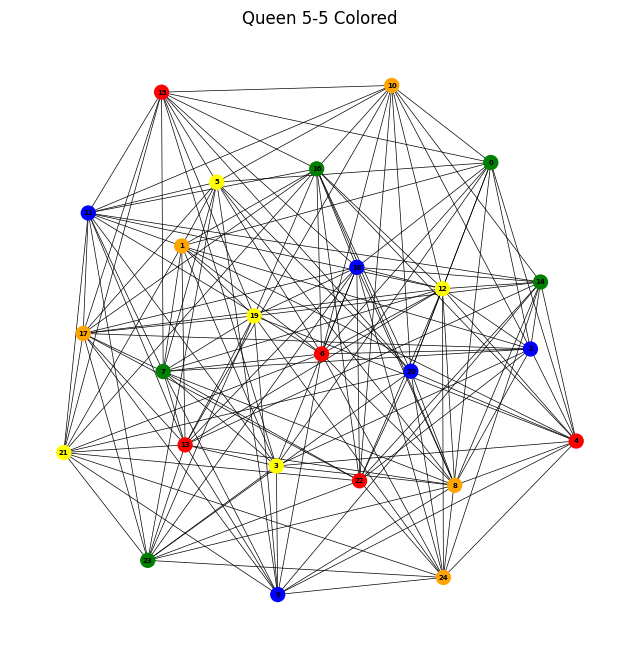

In [ ]:
#First we obtain the node_color and edge_color lists
node_colors, edge_colors = color_lists(G, best_coloring.cpu(), color_map)

#Here we save the graph with this coloring
save_graph(G, node_colors, edge_colors, 'queen5-5-gcn', path = 'graphs/')

#Then we plot the graph
plot_graph(G, node_colors= node_colors, edge_colors=edge_colors, seed=SEED_VALUE, node_size = 100, figsize=8, name='Queen 5-5 Colored')

We can also estimate an upper bound on the chromatic number $\chi$ of every graph with non-zero hard cost $H$ using a simple post-processing algorithm proposed by Schuetz et al. [2022](https://doi.org/10.48550/arXiv.2202.01606) that consists on the following: For a given GNN solution, the algorithm tries to remove remaining color clashes at the expense of one additional color by randomly going through existing clashes and randomly assigning the new color to one of the two nodes at hand.

This can be illustrated in the following diagram:

<!---
The img src like the following works only on Colab. If you're running this from a local machine, the img src should looke like this:
<img src="images/potts.png" style="width:400px;height:300px;">
-->

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1qYaOMeSarhnMYsUHUkUkWZDiao6u4b4b" width = "400" height = "300">
</p>
<p align="center">
<em>Fig 5: Illustration of the algorithm to estimate upper bounds on the chromatic number.</em>
</p>

This algorithm is implemented on the ``new_coloring`` function of the ``utilities.py`` module. Lets implement it for this graph:

In [ ]:
#Here we obtain a new coloring along with the upper bound for the chromatic number
optimized_coloring, upper_chromatic_number = new_coloring(G, best_coloring.cpu())
#Here we print the upper bound for the chromatic number
print(f'The upper bound for the chromatic number is: {upper_chromatic_number}')

The upper bound for the chromatic number is: 5


This, we already knew since $q=5$ is the theoretical value of minimum colors for this graph and our normalized error was $\epsilon =0.0$. Finally, we can print a summary of the results:

In [ ]:
#Here we create a dataframe with the results for the first graph
results = {
    'Graph': 'queen5-5',
    'Nodes': len(G.nodes),
    'Edges': len(G.edges),
    'Density %':nx.density(G)*100,
    'Colors': chromatic_numbers[problem_file],
    'Chromatic Number': upper_chromatic_number.item(),
    'GCN Cost': best_cost,
    'Error %':(best_cost/len(G.edges))*100,
}

print(f"Graph:{results['Graph']} | Nodes:{results['Nodes']} | Edges:{results['Edges']} | Density %:{results['Density %']} | Colors:{results['Colors']} | Chromatic Number:{results['Chromatic Number']} | GCN Cost %:{results['GCN Cost']} | Error %:{results['Error %']}")

Graph:queen5-5 | Nodes:25 | Edges:160 | Density %:53.333333333333336 | Colors:5 | Chromatic Number:5 | GCN Cost %:0.0 | Error %:0.0


Since the ``initial_embedding`` in every problem is initialized randomly, Schuetz et al. comment in another [article](https://arxiv.org/abs/2107.01188) that there is a risk of becoming stuck in a local optimum where the GNN stops learning. This is why, they propose to take multiple shots (i.e., run the GNN training multiple times for different random seeds and choose the best solution), thereby boosting the performance at the cost of extended runtime.

In the case of our project, since we have limited resources, we'll manually re-run the training only in the cases the $H_{Potts}$ is greater than the maximum value obtained by Schuetz et al. with their PI-GNN and PI-SAGE models.

**4.1.- The GraphSAGE COLOR hyperparameters**

The authors GraphSAGE model features several hyperparameters, including the number of layers $K$, the dimensionality of the embedding vectors $\vec{h}_{i}^{k}$, and the learning rate $\beta$. Since hyperparameter optimization is out of scope, we'll use only the hyperparameters presented in Schuetz et al. [2022](https://doi.org/10.48550/arXiv.2202.01606).

For the COLOR graphs, the authors presented the following hyperparameters for the GraphSAGE architecture:

| graph      | colors $q$ | embedding $d_{0}$ | layers $K$ | hidden dim $d_{1}$ | learning rate $\beta$ | dropout | epochs | patience |
|------------|------------|-------------------|------------|--------------------|-----------------------|---------|--------|----------|
| anna       | 11         | 43                | 1          | 22                 | 0.03507               | 0.3298  | 100000 | 500      |
| jean       | 10         | 50                | 1          | 62                 | 0.01663               | 0.3185  | 100000 | 500      |
| myciel5    | 6          | 16                | 1          | 18                 | 0.01333               | 0.3964  | 100000 | 500      |
| myciel6    | 7          | 8                 | 1          | 22                 | 0.01779               | 0.2225  | 100000 | 500      |
| queen5-5   | 5          | 77                | 1          | 32                 | 0.02988               | 0.3784  | 100000 | 500      |
| queen6-6   | 7          | 20                | 1          | 12                 | 0.05105               | 0.3425  | 100000 | 500      |
| queen7-7   | 7          | 67                | 1          | 12                 | 0.02175               | 0.2339  | 100000 | 500      |
| queen8-8   | 9          | 32                | 1          | 10                 | 0.02728               | 0.2878  | 100000 | 500      |
| queen8-12  | 12         | 107               | 1          | 23                 | 0.01730               | 0.1796  | 100000 | 500      |
| queen9-9   | 10         | 109               | 1          | 16                 | 0.02636               | 0.3257  | 100000 | 500      |
| queen11-11 | 11         | 75                | 1          | 25                 | 0.04600               | 0.2974  | 100000 | 500      |

Before starting to train the COLOR datasets using the previous hyperparameters and the GraphSAGE model, we need to define which device and seed to use. We'll set the seed value via the ``set_seed`` function provided by the ``utilities.py``  in order to make sure everything can be reproduced.

In [ ]:
# Here we set the device: GPU/CPU and the type of the tensors to use
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

# Here we fix a seed to ensure consistent results
SEED_VALUE = 4589
set_seed(SEED_VALUE)

Will use device: cuda, torch dtype: torch.float32


**4.2.- The Anna graph**

We will train a GraphSAGE model with the ``anna.col`` graph and its respective hyperparameters.

First, we'll build the anna graph from the COLOR data using the ``NetworkX`` module and then, we define the model hyperparameters. The ``chromatic_numbers`` dictionary contains the $q$ values for all the pertinent graphs given by theoretical results.

In [ ]:
#Here we specify which dataset to use:
problem_file = 'anna.col'

# Here we build the graph for the problem
G_anna = build_color_graph(problem_file)

#Here we define the hyperparameters
hypers_anna = {
    'model': 'GraphSAGE',  # Which model to use
    'initial_dim': 43,  # Dimension of the initial embedding
    'hidden_dim': 22,      # Hidden dimension of the model
    'dropout': 0.3298,     # Dropout rate
    'learning_rate': 0.03507, # Learning rate
    'seed': SEED_VALUE,    # Random seed
    'device': TORCH_DEVICE, # Device to use
    'dtype': TORCH_DTYPE,   # Data type to use
    'number_epochs': int(1e5),   # Max number training steps
    'patience': 500,             # Number early stopping triggers before breaking loop
    'graph_file': problem_file,  # Which problem is being solved
    'number_colors': chromatic_numbers[problem_file], # Number of colors in the problem
    'num_nodes': len(G_anna.nodes) # Number of nodes in the problem
}

For visualization, we can plot the graph using the ``plot_graph``function of the ``utilities.py``module:

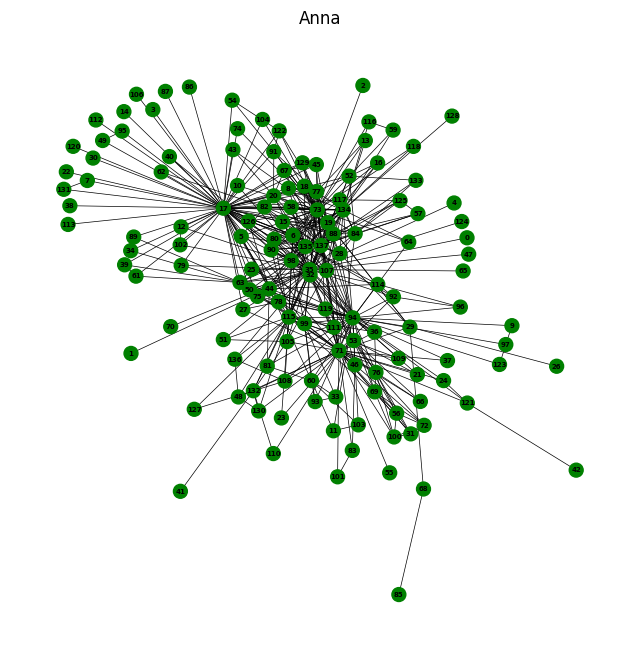

In [ ]:
# Here we plot the graph
plot_graph(G_anna, node_colors= ['green']*len(G_anna.nodes), edge_colors=['black']*len(G_anna.edges), seed=SEED_VALUE, node_size = 100, figsize=8, name = "Anna")

Before training, we need to initialize the model and the optimizer to perform SGD. This is done via the ``initialize_model`` function of the ``utilities.py`` module. By inputting the model hyperparameters, we can initialize the GCN or GraphSAGE model along with the AdamW optimizer:

In [ ]:
net, initial_embedding, optimizer = initialize_model(hypers_anna)

Setting seed to 4589...
Building GraphSAGE model...
Building ADAM-W optimizer...


In order to train the model, we obtain the ``edge_index`` of the graph, that is a tensor that encodes the source and target nodes of all edges. This is a tensor defined in COO format, the where specified elements are stored as tuples of element indices and their corresponding values, which is useful when training with Pytorch Geometric. This is done by the ``get_edge_index`` function of the ``utilities.py`` module.


Finally we perform the training as mentioned before, using the ``training`` function of the ``utilities.py`` module and obtain:

- ``probs``: The probabilities of each node belonging to a given class (or color). This is the output of the hidden GNN layer of the model after being processed by a Softmax function.

- ``best_coloring``: The best coloring for the graph found during training. This is obtained by applying an Argmax function to the ``probs`` in order to get a hard representation of the probabilities.

- ``best_loss``: $\mathbf{L}$ that is the smallest soft loss found during training (calculated using the probabilities as mentioned earlier).  This is done via the ``potts_soft_loss`` function of the ``utilities.py`` module.

- ``best_cost``: The smallest hard loss $H_{\text{Potts}}$ found during training (calculated using the best coloring and the graph itself). This is done via the ``potts_hard_loss`` function of the ``utilities.py`` module.

In [ ]:
probs_anna, best_coloring_anna, best_loss_anna, best_cost_anna = training(G_anna, net, initial_embedding, optimizer, hypers_anna, verbose=True)

Setting seed to 4589...
Epoch: 0 | Soft Loss: 46.946136474609375 | Hard Loss: 144.0 | Patience: 0
Epoch: 1000 | Soft Loss: 1.1628227233886719 | Hard Loss: 1.0 | Patience: 1
Epoch: 2000 | Soft Loss: 1.0001630783081055 | Hard Loss: 1.0 | Patience: 1
Epoch: 3000 | Soft Loss: 1.0 | Hard Loss: 1.0 | Patience: 0
Epoch: 4000 | Soft Loss: 1.0172163248062134 | Hard Loss: 1.0 | Patience: 0
Epoch: 5000 | Soft Loss: 1.0148694515228271 | Hard Loss: 1.0 | Patience: 1
Epoch: 6000 | Soft Loss: 2.0000224113464355 | Hard Loss: 2.0 | Patience: 2
Epoch: 7000 | Soft Loss: 2.0803451538085938 | Hard Loss: 2.0 | Patience: 0
Epoch: 8000 | Soft Loss: 1.0001198053359985 | Hard Loss: 1.0 | Patience: 1
Epoch: 9000 | Soft Loss: 2.0000007152557373 | Hard Loss: 2.0 | Patience: 3
Epoch: 10000 | Soft Loss: 1.0 | Hard Loss: 1.0 | Patience: 0
Epoch: 11000 | Soft Loss: 2.0000743865966797 | Hard Loss: 2.0 | Patience: 2
Epoch: 12000 | Soft Loss: 5.026146254749619e-07 | Hard Loss: 0.0 | Patience: 0
Epoch: 13000 | Soft Loss: 

The authors define a normalized error $\epsilon = H_{\text{Potts}}/|\mathbf{E}|$, where $\mathbf{E}$ is the number of edges in the graph to assess the quality of the solution given by a GNN model, quantifying the number of color clashes normalized by the number of edges. We can easily calculate the normalized error for the anna graph as:

In [ ]:
print(f'In this case, the normalized error is: {best_cost_anna/len(G_anna.edges)}')

In this case, the normalized error is: 0.0


This means that we found an optimal coloring where there are no color clashes. If we want to plot the graph with the ``best_coloring`` we can do it using the ``plot_graph``function of the ``utilities.py`` module by first obtaining lists with node and edge colors using the ``color_lists`` function of the ``utilities.py`` module:

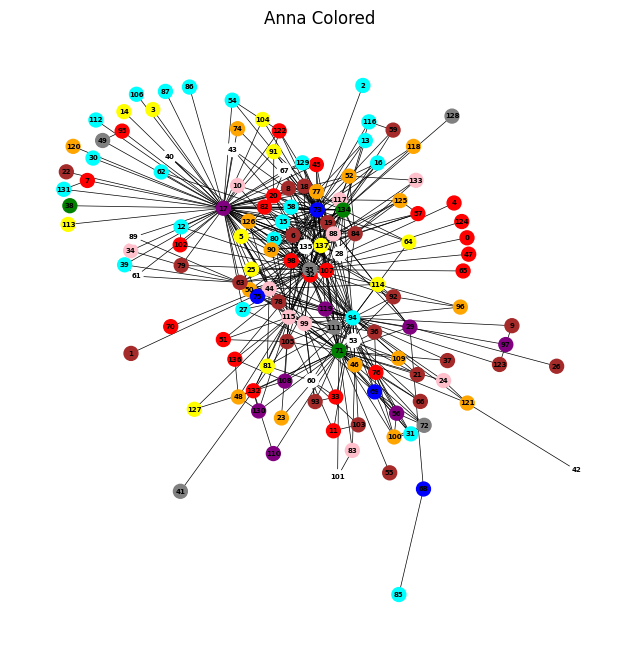

In [ ]:
#First we obtain the node_color and edge_color lists
node_colors_anna, edge_colors_anna = color_lists(G_anna, best_coloring_anna.cpu(), color_map)

#Here we save the graph with this coloring
save_graph(G_anna, node_colors_anna, edge_colors_anna, 'anna', path = 'graphs/')

#Then we plot the graph
plot_graph(G_anna, node_colors= node_colors_anna, edge_colors=edge_colors_anna, seed=SEED_VALUE, node_size = 100, figsize=8, name='Anna Colored')

We can also estimate an upper bound on the chromatic number $\chi$ of every graph with non-zero hard cost $H$ using the simple post-processing algorithm proposed by Schuetz et al. [2022](https://doi.org/10.48550/arXiv.2202.01606). This algorithm is implemented on the ``new_coloring`` function of the ``utilities.py`` module. Lets implement it for this graph:

In [ ]:
#Here we obtain a new coloring along with the upper bound for the chromatic number
optimized_coloring_anna, upper_chromatic_number_anna = new_coloring(G_anna, best_coloring_anna.cpu())
#Here we print the upper bound for the chromatic number
print(f'The upper bound for the chromatic number is: {upper_chromatic_number_anna}')

The upper bound for the chromatic number is: 11


This, we already knew since $q=11$ is the theoretical value of minimum colors for this graph and our normalized error was $\epsilon =0.0$. Finally, we can save all the variables of interest (normalized error and the upper bound for the chromatic number) in lists in order to create a Dataframe with the data from all the results.

In [ ]:
#Here we create a dataframe with the results for the first graph
results_anna = {
    'Graph': ['anna'],
    'Nodes': [len(G_anna.nodes)],
    'Edges': [len(G_anna.edges)],
    'Density %':[nx.density(G_anna)*100],
    'Colors': [chromatic_numbers[problem_file]],
    'Chromatic Number': [upper_chromatic_number_anna.item()],
    'GraphSAGE Cost': [best_cost_anna],
    'Error %':[(best_cost_anna/len(G_anna.edges))*100],
}

#Here we create the DataFrame
color_results = pd.DataFrame(results_anna)

#Here we save it, the path can simply be the name of the file if we're not in Drive
color_results.to_csv('color_results.csv', index=False)

#Here we print the dataframe
color_results.head()

Graph  Nodes  Edges  Density %  Colors  Chromatic Number  GraphSAGE Cost  \
0  anna    138    493   5.215276      11                11             0.0   

   Error %  
0      0.0

**4.3.- The Jean graph**

Now, we will train our GraphSAGE model with the ``jean.col`` graph and its respective hyperparameters. Since the main explanation of the used method for the COLOR graphs was done with the first two examples, for this case we'll run everything in one cell of code.


Will use device: cuda, torch dtype: torch.float32
Setting seed to 8111...
Building GraphSAGE model...
Building ADAM-W optimizer...
Setting seed to 8111...
Epoch: 0 | Soft Loss: 26.481056213378906 | Hard Loss: 51.0 | Patience: 0
Epoch: 1000 | Soft Loss: 3.477268182905391e-05 | Hard Loss: 0.0 | Patience: 2
Epoch: 2000 | Soft Loss: 0.9999849200248718 | Hard Loss: 1.0 | Patience: 2
Epoch: 3000 | Soft Loss: 8.899474039647526e-12 | Hard Loss: 0.0 | Patience: 0
Epoch: 4000 | Soft Loss: 7.459399885159732e-16 | Hard Loss: 0.0 | Patience: 0
Epoch: 5000 | Soft Loss: 0.9919435381889343 | Hard Loss: 1.0 | Patience: 2
Epoch: 6000 | Soft Loss: 3.6933517549186945e-05 | Hard Loss: 0.0 | Patience: 4
Epoch: 7000 | Soft Loss: 8.639109935239253e-13 | Hard Loss: 0.0 | Patience: 4
Epoch: 8000 | Soft Loss: 1.0 | Hard Loss: 1.0 | Patience: 25
Epoch: 9000 | Soft Loss: 1.3077628290741393e-18 | Hard Loss: 0.0 | Patience: 10
Epoch: 10000 | Soft Loss: 0.004907846450805664 | Hard Loss: 0.0 | Patience: 5
Epoch: 11000

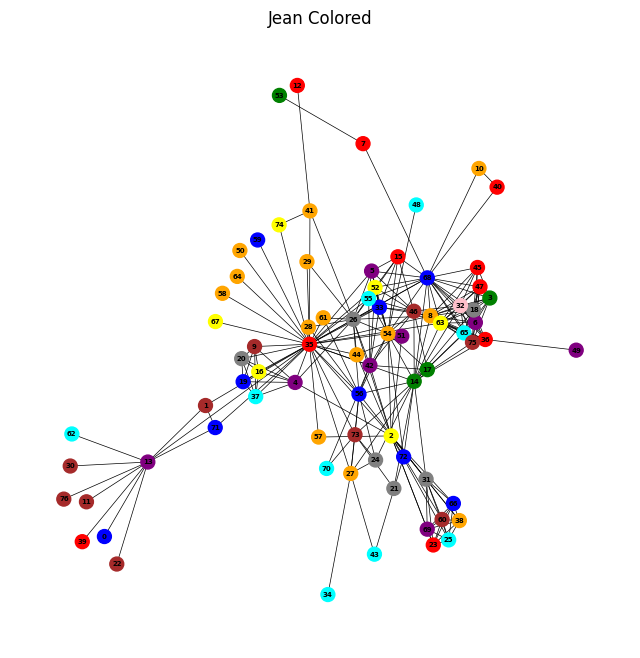

In [ ]:
# Here we set the device: GPU/CPU and the type of the tensors to use
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

# Here we fix a seed to ensure consistent results
SEED_VALUE = 8111
set_seed(SEED_VALUE)

#Here we specify which dataset to use:
problem_file = 'jean.col'

# Here we build the graph for the problem
G_jean = build_color_graph(problem_file)

#Here we define the hyperparameters
hypers_jean = {
    'model': 'GraphSAGE',  # Which model to use
    'initial_dim': 50,  # Dimension of the initial embedding
    'hidden_dim': 62,      # Hidden dimension of the model
    'dropout': 0.3185,     # Dropout rate
    'learning_rate': 0.01663, # Learning rate
    'seed': SEED_VALUE,    # Random seed
    'device': TORCH_DEVICE, # Device to use
    'dtype': TORCH_DTYPE,   # Data type to use
    'number_epochs': int(1e5),   # Max number training steps
    'patience': 500,             # Number early stopping triggers before breaking loop
    'graph_file': problem_file,  # Which problem is being solved
    'number_colors': chromatic_numbers[problem_file], # Number of colors in the problem
    'num_nodes': len(G_jean.nodes) # Number of nodes in the problem
}

#Here we initialize the model
net, initial_embedding, optimizer = initialize_model(hypers_jean)

#Here we train the model
probs_jean, best_coloring_jean, best_loss_jean, best_cost_jean = training(G_jean, net, initial_embedding, optimizer, hypers_jean, verbose=True)
print(f'In this case, the normalized error is: {best_cost_jean/len(G_jean.edges)}')

#Here we obtain a new coloring along with the upper bound for the chromatic number
optimized_coloring_jean, upper_chromatic_number_jean = new_coloring(G_jean, best_coloring_jean.cpu())
print(f'The upper bound for the chromatic number is: {upper_chromatic_number_jean}')

#Here we concatenate a dataframe with the results for this graph to the results of the other graphs and save it
results_jean = {
    'Graph': 'jean',
    'Nodes': len(G_jean.nodes),
    'Edges': len(G_jean.edges),
    'Density %':nx.density(G_jean)*100,
    'Colors': chromatic_numbers[problem_file],
    'Chromatic Number': upper_chromatic_number_jean.item(),
    'GraphSAGE Cost': best_cost_jean,
    'Error %':(best_cost_jean/len(G_jean.edges))*100,
}
color_results = pd.read_csv('color_results.csv')
color_results = pd.concat([color_results, pd.DataFrame([results_jean])], ignore_index=True)
color_results.to_csv('color_results.csv', index=False)

#Finally we plot the graph with the coloring
node_colors_jean, edge_colors_jean = color_lists(G_jean, best_coloring_jean.cpu(), color_map)
#Here we save the graph with this coloring
save_graph(G_jean, node_colors_jean, edge_colors_jean, 'jean', path = 'graphs/')
#Then we plot the graph
plot_graph(G_jean, node_colors= node_colors_jean, edge_colors=edge_colors_jean, seed=SEED_VALUE, node_size = 100, figsize=8, name='Jean Colored')

**4.4.- The Myciel5 graph**

Now, we will train our GraphSAGE model with the ``myciel5.col`` graph and its respective hyperparameters.

Will use device: cuda, torch dtype: torch.float32
Setting seed to 8111...
Building GraphSAGE model...
Building ADAM-W optimizer...
Setting seed to 8111...
Epoch: 0 | Soft Loss: 42.02120590209961 | Hard Loss: 84.0 | Patience: 0
Epoch: 1000 | Soft Loss: 0.005522638559341431 | Hard Loss: 0.0 | Patience: 0
Epoch: 2000 | Soft Loss: 1.0017304420471191 | Hard Loss: 1.0 | Patience: 2
Epoch: 3000 | Soft Loss: 0.005290486849844456 | Hard Loss: 0.0 | Patience: 0
Epoch: 4000 | Soft Loss: 0.04843325912952423 | Hard Loss: 0.0 | Patience: 2
Epoch: 5000 | Soft Loss: 6.364470755215734e-05 | Hard Loss: 0.0 | Patience: 0
Epoch: 6000 | Soft Loss: 0.015452624298632145 | Hard Loss: 0.0 | Patience: 2
Epoch: 7000 | Soft Loss: 0.06410747021436691 | Hard Loss: 0.0 | Patience: 2
Epoch: 8000 | Soft Loss: 6.266703712753952e-05 | Hard Loss: 0.0 | Patience: 1
Epoch: 9000 | Soft Loss: 0.0007100875955075026 | Hard Loss: 0.0 | Patience: 2
Epoch: 10000 | Soft Loss: 2.049730574071873e-05 | Hard Loss: 0.0 | Patience: 2
Ep

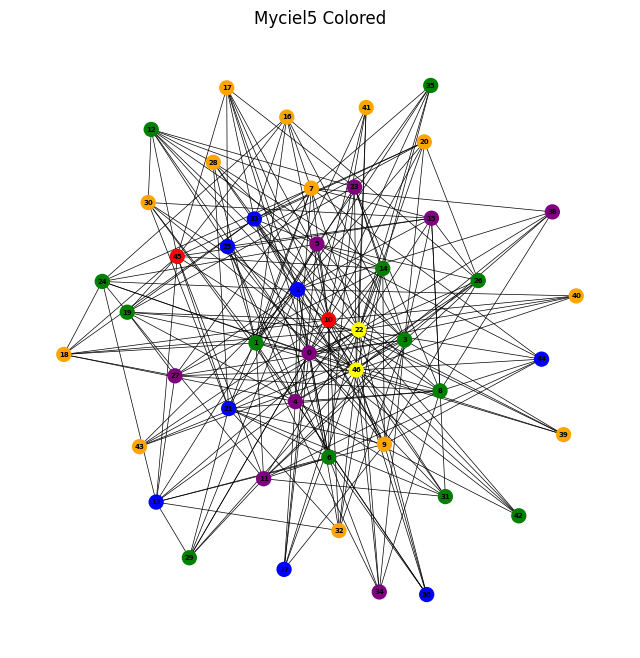

In [ ]:
# Here we set the device: GPU/CPU and the type of the tensors to use
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

# Here we fix a seed to ensure consistent results
SEED_VALUE = 8111
set_seed(SEED_VALUE)

#Here we specify which dataset to use:
problem_file = 'myciel5.col'

# Here we build the graph for the problem
G_myciel5 = build_color_graph(problem_file)

#Here we define the hyperparameters
hypers_myciel5 = {
    'model': 'GraphSAGE',  # Which model to use
    'initial_dim': 16,  # Dimension of the initial embedding
    'hidden_dim': 18,      # Hidden dimension of the model
    'dropout': 0.3864,     # Dropout rate
    'learning_rate': 0.01333, # Learning rate
    'seed': SEED_VALUE,    # Random seed
    'device': TORCH_DEVICE, # Device to use
    'dtype': TORCH_DTYPE,   # Data type to use
    'number_epochs': int(1e5),   # Max number training steps
    'patience': 500,             # Number early stopping triggers before breaking loop
    'graph_file': problem_file,  # Which problem is being solved
    'number_colors': chromatic_numbers[problem_file], # Number of colors in the problem
    'num_nodes': len(G_myciel5.nodes) # Number of nodes in the problem
}

#Here we initialize the model
net, initial_embedding, optimizer = initialize_model(hypers_myciel5)

#Here we train the model
probs_myciel5, best_coloring_myciel5, best_loss_myciel5, best_cost_myciel5 = training(G_myciel5, net, initial_embedding, optimizer, hypers_myciel5, verbose=True)
print(f'In this case, the normalized error is: {best_cost_myciel5/len(G_myciel5.edges)}')

#Here we obtain a new coloring along with the upper bound for the chromatic number
optimized_coloring_myciel5, upper_chromatic_number_myciel5 = new_coloring(G_myciel5, best_coloring_myciel5.cpu())
print(f'The upper bound for the chromatic number is: {upper_chromatic_number_myciel5}')

#Here we concatenate a dataframe with the results for this graph to the results of the other graphs and save it
results_myciel5 = {
    'Graph': 'myciel5',
    'Nodes': len(G_myciel5.nodes),
    'Edges': len(G_myciel5.edges),
    'Density %':nx.density(G_myciel5)*100,
    'Colors': chromatic_numbers[problem_file],
    'Chromatic Number': upper_chromatic_number_myciel5.item(),
    'GraphSAGE Cost': best_cost_myciel5,
    'Error %':(best_cost_myciel5/len(G_myciel5.edges))*100,
}
color_results = pd.read_csv('color_results.csv')
color_results = pd.concat([color_results, pd.DataFrame([results_myciel5])], ignore_index=True)
color_results.to_csv('color_results.csv', index=False)

#Finally we plot the graph with the coloring
node_colors_myciel5, edge_colors_myciel5 = color_lists(G_myciel5, best_coloring_myciel5.cpu(), color_map)
#Here we save the graph with this coloring
save_graph(G_myciel5, node_colors_myciel5, edge_colors_myciel5, 'myciel5', path = 'graphs/')
#Then we plot the graph
plot_graph(G_myciel5, node_colors= node_colors_myciel5, edge_colors=edge_colors_myciel5, seed=SEED_VALUE, node_size = 100, figsize=8, name='Myciel5 Colored')

**4.4.- The Myciel6 graph**

Now, we will train our GraphSAGE model with the ``myciel6.col`` graph and its respective hyperparameters.

Will use device: cuda, torch dtype: torch.float32
Setting seed to 8111...
Building GraphSAGE model...
Building ADAM-W optimizer...
Setting seed to 8111...
Epoch: 0 | Soft Loss: 112.02816009521484 | Hard Loss: 312.0 | Patience: 0
Epoch: 1000 | Soft Loss: 0.04029590263962746 | Hard Loss: 0.0 | Patience: 0
Epoch: 2000 | Soft Loss: 0.05391600728034973 | Hard Loss: 0.0 | Patience: 1
Epoch: 3000 | Soft Loss: 0.00610093679279089 | Hard Loss: 0.0 | Patience: 0
Epoch: 4000 | Soft Loss: 0.024906791746616364 | Hard Loss: 0.0 | Patience: 6
Epoch: 5000 | Soft Loss: 0.0162869393825531 | Hard Loss: 0.0 | Patience: 0
Epoch: 6000 | Soft Loss: 0.04306507855653763 | Hard Loss: 0.0 | Patience: 1
Epoch: 7000 | Soft Loss: 0.001834926544688642 | Hard Loss: 0.0 | Patience: 0
Epoch: 8000 | Soft Loss: 0.0039704712107777596 | Hard Loss: 0.0 | Patience: 0
Epoch: 9000 | Soft Loss: 0.018194083124399185 | Hard Loss: 0.0 | Patience: 0
Epoch: 10000 | Soft Loss: 0.0033122659660875797 | Hard Loss: 0.0 | Patience: 3
Epoc

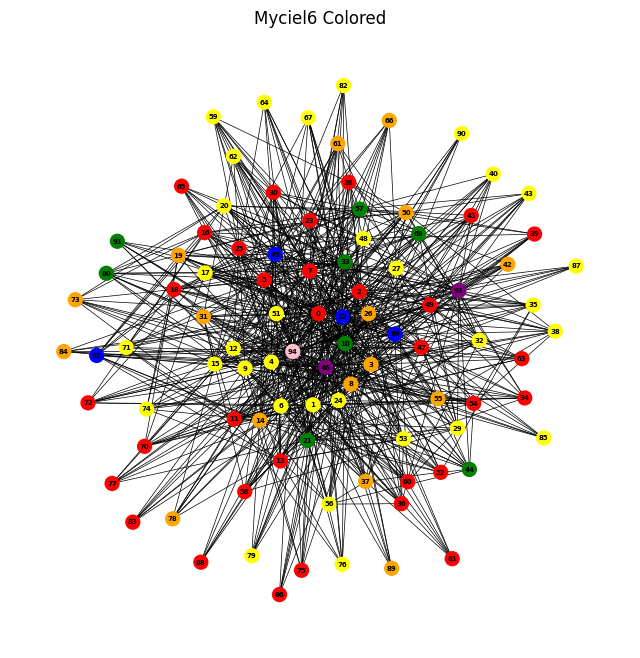

In [ ]:
# Here we set the device: GPU/CPU and the type of the tensors to use
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

# Here we fix a seed to ensure consistent results
SEED_VALUE = 8111
set_seed(SEED_VALUE)

#Here we specify which dataset to use:
problem_file = 'myciel6.col'

# Here we build the graph for the problem
G_myciel6 = build_color_graph(problem_file)

#Here we define the hyperparameters
hypers_myciel6 = {
    'model': 'GraphSAGE',  # Which model to use
    'initial_dim': 8,  # Dimension of the initial embedding
    'hidden_dim': 22,      # Hidden dimension of the model
    'dropout': 0.2225,     # Dropout rate
    'learning_rate': 0.01779, # Learning rate
    'seed': SEED_VALUE,    # Random seed
    'device': TORCH_DEVICE, # Device to use
    'dtype': TORCH_DTYPE,   # Data type to use
    'number_epochs': int(1e5),   # Max number training steps
    'patience': 500,             # Number early stopping triggers before breaking loop
    'graph_file': problem_file,  # Which problem is being solved
    'number_colors': chromatic_numbers[problem_file], # Number of colors in the problem
    'num_nodes': len(G_myciel6.nodes) # Number of nodes in the problem
}

#Here we initialize the model
net, initial_embedding, optimizer = initialize_model(hypers_myciel6)

#Here we train the model
probs_myciel6, best_coloring_myciel6, best_loss_myciel6, best_cost_myciel6 = training(G_myciel6, net, initial_embedding, optimizer, hypers_myciel6, verbose=True)
print(f'In this case, the normalized error is: {best_cost_myciel6/len(G_myciel6.edges)}')

#Here we obtain a new coloring along with the upper bound for the chromatic number
optimized_coloring_myciel6, upper_chromatic_number_myciel6 = new_coloring(G_myciel6, best_coloring_myciel6.cpu())
print(f'The upper bound for the chromatic number is: {upper_chromatic_number_myciel6}')

#Here we concatenate a dataframe with the results for this graph to the results of the other graphs and save it
results_myciel6 = {
    'Graph': 'myciel6',
    'Nodes': len(G_myciel6.nodes),
    'Edges': len(G_myciel6.edges),
    'Density %':nx.density(G_myciel6)*100,
    'Colors': chromatic_numbers[problem_file],
    'Chromatic Number': upper_chromatic_number_myciel6.item(),
    'GraphSAGE Cost': best_cost_myciel6,
    'Error %':(best_cost_myciel6/len(G_myciel6.edges))*100,
}
color_results = pd.read_csv('color_results.csv')
color_results = pd.concat([color_results, pd.DataFrame([results_myciel6])], ignore_index=True)
color_results.to_csv('color_results.csv', index=False)

#Finally we plot the graph with the coloring
node_colors_myciel6, edge_colors_myciel6 = color_lists(G_myciel6, best_coloring_myciel6.cpu(), color_map)
#Here we save the graph with this coloring
save_graph(G_myciel6, node_colors_myciel6, edge_colors_myciel6, 'myciel6', path = 'graphs/')
#Then we plot the graph
plot_graph(G_myciel6, node_colors= node_colors_myciel6, edge_colors=edge_colors_myciel6, seed=SEED_VALUE, node_size = 100, figsize=8, name='Myciel6 Colored')

**4.5.- The Queen5-5 graph**

Now, we will train our GraphSAGE model with the ``queen5_5.col`` graph and its respective hyperparameters.

Will use device: cuda, torch dtype: torch.float32
Setting seed to 8111...
Building GraphSAGE model...
Building ADAM-W optimizer...
Setting seed to 8111...
Epoch: 0 | Soft Loss: 32.14834213256836 | Hard Loss: 41.0 | Patience: 0
Epoch: 1000 | Soft Loss: 0.0012163841165602207 | Hard Loss: 0.0 | Patience: 0
Epoch: 2000 | Soft Loss: 2.0134649156289264e-11 | Hard Loss: 0.0 | Patience: 0
Epoch: 3000 | Soft Loss: 0.034972645342350006 | Hard Loss: 0.0 | Patience: 18
Epoch: 4000 | Soft Loss: 5.246977852202406e-10 | Hard Loss: 0.0 | Patience: 0
Epoch: 5000 | Soft Loss: 3.0006470680236816 | Hard Loss: 3.0 | Patience: 5
Epoch: 6000 | Soft Loss: 2.293323730215247e-26 | Hard Loss: 0.0 | Patience: 8
Epoch: 7000 | Soft Loss: 3.0507074794511823e-16 | Hard Loss: 0.0 | Patience: 0
Epoch: 8000 | Soft Loss: 0.0 | Hard Loss: 0.0 | Patience: 14
Epoch: 9000 | Soft Loss: 2.780378928519764e-19 | Hard Loss: 0.0 | Patience: 2
Epoch: 10000 | Soft Loss: 7.991458072323805e-19 | Hard Loss: 0.0 | Patience: 0
Epoch: 110

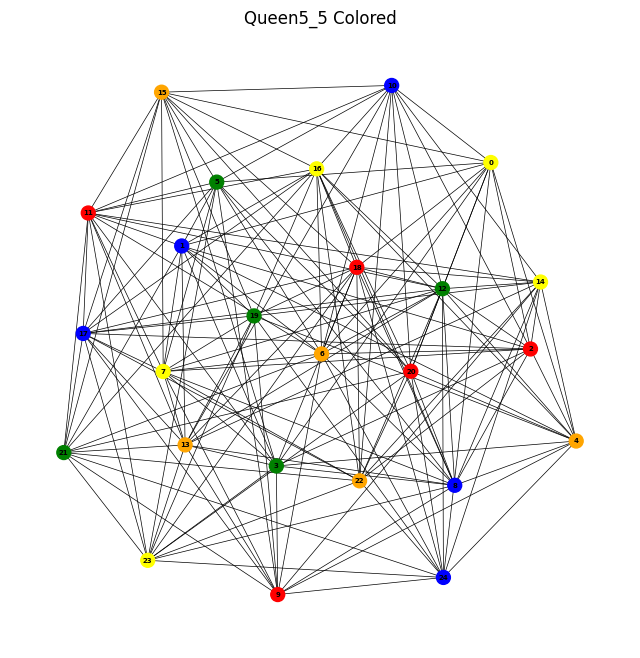

In [ ]:
# Here we set the device: GPU/CPU and the type of the tensors to use
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

# Here we fix a seed to ensure consistent results
SEED_VALUE = 8111
set_seed(SEED_VALUE)

#Here we specify which dataset to use:
problem_file = 'queen5_5.col'

# Here we build the graph for the problem
G_queen5_5 = build_color_graph(problem_file)

#Here we define the hyperparameters
hypers_queen5_5 = {
    'model': 'GraphSAGE',  # Which model to use
    'initial_dim': 77,  # Dimension of the initial embedding
    'hidden_dim': 32,      # Hidden dimension of the model
    'dropout': 0.3784,     # Dropout rate
    'learning_rate': 0.02988, # Learning rate
    'seed': SEED_VALUE,    # Random seed
    'device': TORCH_DEVICE, # Device to use
    'dtype': TORCH_DTYPE,   # Data type to use
    'number_epochs': int(1e5),   # Max number training steps
    'patience': 500,             # Number early stopping triggers before breaking loop
    'graph_file': problem_file,  # Which problem is being solved
    'number_colors': chromatic_numbers[problem_file], # Number of colors in the problem
    'num_nodes': len(G_queen5_5.nodes) # Number of nodes in the problem
}

#Here we initialize the model
net, initial_embedding, optimizer = initialize_model(hypers_queen5_5)

#Here we train the model
probs_queen5_5, best_coloring_queen5_5, best_loss_queen5_5, best_cost_queen5_5 = training(G_queen5_5, net, initial_embedding, optimizer, hypers_queen5_5, verbose=True)
print(f'In this case, the normalized error is: {best_cost_queen5_5/len(G_queen5_5.edges)}')

#Here we obtain a new coloring along with the upper bound for the chromatic number
optimized_coloring_queen5_5, upper_chromatic_number_queen5_5 = new_coloring(G_queen5_5, best_coloring_queen5_5.cpu())
print(f'The upper bound for the chromatic number is: {upper_chromatic_number_queen5_5}')

#Here we concatenate a dataframe with the results for this graph to the results of the other graphs and save it
results_queen5_5 = {
    'Graph': 'queen5_5',
    'Nodes': len(G_queen5_5.nodes),
    'Edges': len(G_queen5_5.edges),
    'Density %':nx.density(G_queen5_5)*100,
    'Colors': chromatic_numbers[problem_file],
    'Chromatic Number': upper_chromatic_number_queen5_5.item(),
    'GraphSAGE Cost': best_cost_queen5_5,
    'Error %':(best_cost_queen5_5/len(G_queen5_5.edges))*100,
}
color_results = pd.read_csv('color_results.csv')
color_results = pd.concat([color_results, pd.DataFrame([results_queen5_5])], ignore_index=True)
color_results.to_csv('color_results.csv', index=False)

#Finally we plot the graph with the coloring
node_colors_queen5_5, edge_colors_queen5_5 = color_lists(G_queen5_5, best_coloring_queen5_5.cpu(), color_map)
#Here we save the graph with this coloring
save_graph(G_queen5_5, node_colors_queen5_5, edge_colors_queen5_5, 'queen5_5', path = 'graphs/')
#Then we plot the graph
plot_graph(G_queen5_5, node_colors= node_colors_queen5_5, edge_colors=edge_colors_queen5_5, seed=SEED_VALUE, node_size = 100, figsize=8, name='Queen5_5 Colored')

**4.6.- The Queen6-6 graph**

Now, we will train our GraphSAGE model with the ``queen6_6.col`` graph and its respective hyperparameters.

Will use device: cuda, torch dtype: torch.float32
Setting seed to 10...
Building GraphSAGE model...
Building ADAM-W optimizer...
Setting seed to 10...
Epoch: 0 | Soft Loss: 43.756126403808594 | Hard Loss: 158.0 | Patience: 0
Epoch: 1000 | Soft Loss: 9.111212730407715 | Hard Loss: 9.0 | Patience: 0
Epoch: 2000 | Soft Loss: 5.061190605163574 | Hard Loss: 5.0 | Patience: 1
Epoch: 3000 | Soft Loss: 4.0048723220825195 | Hard Loss: 4.0 | Patience: 0
Epoch: 4000 | Soft Loss: 5.697081089019775 | Hard Loss: 6.0 | Patience: 2
Epoch: 5000 | Soft Loss: 4.507147789001465 | Hard Loss: 4.0 | Patience: 1
Epoch: 6000 | Soft Loss: 12.53765869140625 | Hard Loss: 8.0 | Patience: 1
Epoch: 7000 | Soft Loss: 4.029922008514404 | Hard Loss: 4.0 | Patience: 0
Epoch: 8000 | Soft Loss: 4.556778430938721 | Hard Loss: 5.0 | Patience: 0
Epoch: 9000 | Soft Loss: 10.44449234008789 | Hard Loss: 9.0 | Patience: 3
Epoch: 10000 | Soft Loss: 6.684489727020264 | Hard Loss: 7.0 | Patience: 2
Epoch: 11000 | Soft Loss: 7.89169

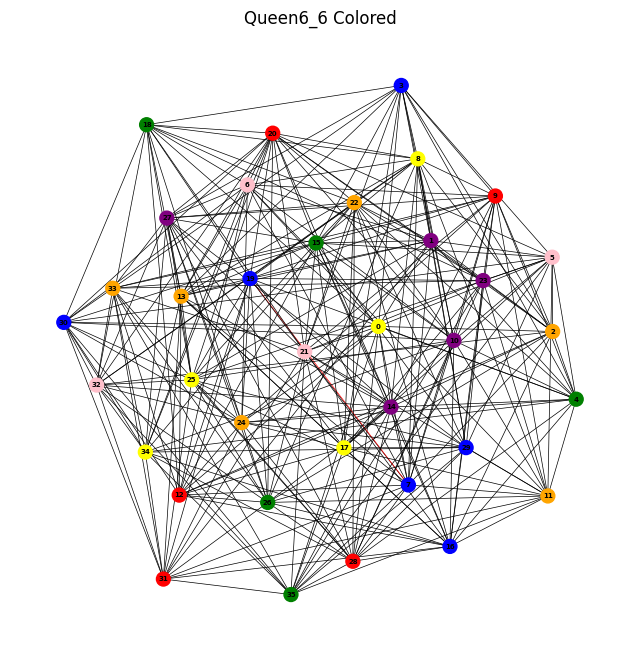

In [ ]:
# Here we set the device: GPU/CPU and the type of the tensors to use
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

# Here we fix a seed to ensure consistent results 27156
SEED_VALUE = 10
set_seed(SEED_VALUE)

#Here we specify which dataset to use:
problem_file = 'queen6_6.col'

# Here we build the graph for the problem
G_queen6_6 = build_color_graph(problem_file)

#Here we define the hyperparameters
hypers_queen6_6 = {
    'model': 'GraphSAGE',  # Which model to use
    'initial_dim': 20,  # Dimension of the initial embedding
    'hidden_dim': 12,      # Hidden dimension of the model
    'dropout': 0.3425,     # Dropout rate
    'learning_rate': 0.05105, # Learning rate
    'seed': SEED_VALUE,    # Random seed
    'device': TORCH_DEVICE, # Device to use
    'dtype': TORCH_DTYPE,   # Data type to use
    'number_epochs': int(1e5),   # Max number training steps
    'patience': 500,             # Number early stopping triggers before breaking loop
    'graph_file': problem_file,  # Which problem is being solved
    'number_colors': chromatic_numbers[problem_file], # Number of colors in the problem
    'num_nodes': len(G_queen6_6.nodes) # Number of nodes in the problem
}

#Here we initialize the model
net, initial_embedding, optimizer = initialize_model(hypers_queen6_6)

#Here we train the model
probs_queen6_6, best_coloring_queen6_6, best_loss_queen6_6, best_cost_queen6_6 = training(G_queen6_6, net, initial_embedding, optimizer, hypers_queen6_6, verbose=True)
print(f'In this case, the normalized error is: {best_cost_queen6_6/len(G_queen6_6.edges)}')

#Here we obtain a new coloring along with the upper bound for the chromatic number
optimized_coloring_queen6_6, upper_chromatic_number_queen6_6 = new_coloring(G_queen6_6, best_coloring_queen6_6.cpu())
print(f'The upper bound for the chromatic number is: {upper_chromatic_number_queen6_6}')

#Here we concatenate a dataframe with the results for this graph to the results of the other graphs and save it
results_queen6_6 = {
    'Graph': 'queen6_6',
    'Nodes': len(G_queen6_6.nodes),
    'Edges': len(G_queen6_6.edges),
    'Density %':nx.density(G_queen6_6)*100,
    'Colors': chromatic_numbers[problem_file],
    'Chromatic Number': upper_chromatic_number_queen6_6.item(),
    'GraphSAGE Cost': best_cost_queen6_6,
    'Error %':(best_cost_queen6_6/len(G_queen6_6.edges))*100,
}
color_results = pd.read_csv('color_results.csv')
color_results = pd.concat([color_results, pd.DataFrame([results_queen6_6])], ignore_index=True)
color_results.to_csv('color_results.csv', index=False)

#Finally we plot the graph with the coloring
node_colors_queen6_6, edge_colors_queen6_6 = color_lists(G_queen6_6, best_coloring_queen6_6.cpu(), color_map)
#Here we save the graph with this coloring
save_graph(G_queen6_6, node_colors_queen6_6, edge_colors_queen6_6, 'queen6_6', path = 'graphs/')
#Then we plot the graph
plot_graph(G_queen6_6, node_colors= node_colors_queen6_6, edge_colors=edge_colors_queen6_6, seed=SEED_VALUE, node_size = 100, figsize=8, name='Queen6_6 Colored')

As we can see, in this case there is a color conflict between nodes: 19 and 7. This conflict can be solved using the heuristic algorithm in ``new_coloring`` by adding one more color instead of the original $q=7$ colors. This is why, we found that $\chi = 8$. The graph with the new coloring would look like this:

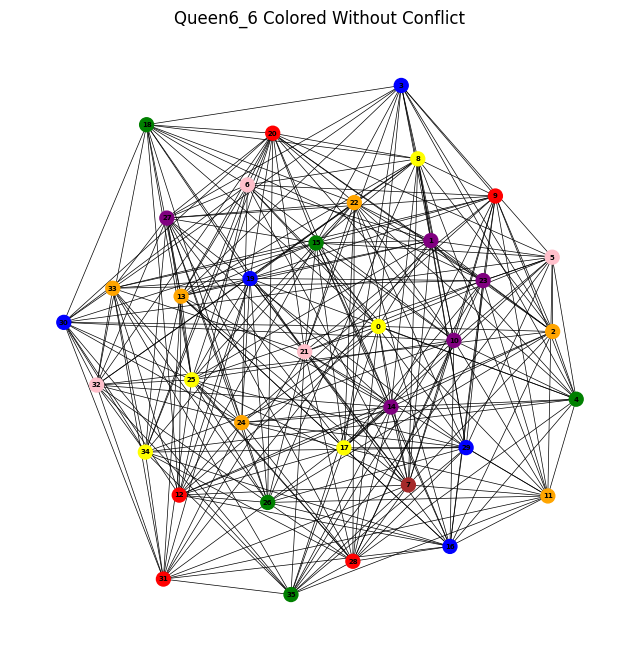

In [ ]:
#Finally we plot the graph with the coloring
new_node_colors_queen6_6, new_edge_colors_queen6_6 = color_lists(G_queen6_6, optimized_coloring_queen6_6.cpu(), color_map)
#Here we save the graph with this coloring
save_graph(G_queen6_6, new_node_colors_queen6_6, new_edge_colors_queen6_6, 'queen6_6_new', path = 'graphs/')
#Then we plot the graph
plot_graph(G_queen6_6, node_colors= new_node_colors_queen6_6, edge_colors=new_edge_colors_queen6_6, seed=SEED_VALUE, node_size = 100, figsize=8, name='Queen6_6 Colored Without Conflict')

**4.7.- The Queen7-7 graph**

Now, we will train our GraphSAGE model with the ``queen7_7.col`` graph and its respective hyperparameters.

Will use device: cuda, torch dtype: torch.float32
Setting seed to 46464...
Building GraphSAGE model...
Building ADAM-W optimizer...
Setting seed to 46464...
Epoch: 0 | Soft Loss: 69.24214172363281 | Hard Loss: 126.0 | Patience: 0
Epoch: 1000 | Soft Loss: 17.01129913330078 | Hard Loss: 17.0 | Patience: 0
Epoch: 2000 | Soft Loss: 15.614148139953613 | Hard Loss: 16.0 | Patience: 0
Epoch: 3000 | Soft Loss: 14.006123542785645 | Hard Loss: 14.0 | Patience: 0
Epoch: 4000 | Soft Loss: 14.21845817565918 | Hard Loss: 14.0 | Patience: 1
Epoch: 5000 | Soft Loss: 26.789382934570312 | Hard Loss: 27.0 | Patience: 2
Epoch: 6000 | Soft Loss: 14.000041961669922 | Hard Loss: 14.0 | Patience: 0
Epoch: 7000 | Soft Loss: 14.056220054626465 | Hard Loss: 14.0 | Patience: 1
Epoch: 8000 | Soft Loss: 15.496054649353027 | Hard Loss: 15.0 | Patience: 4
Epoch: 9000 | Soft Loss: 14.000031471252441 | Hard Loss: 14.0 | Patience: 0
Epoch: 10000 | Soft Loss: 14.008698463439941 | Hard Loss: 14.0 | Patience: 0
Epoch: 1100

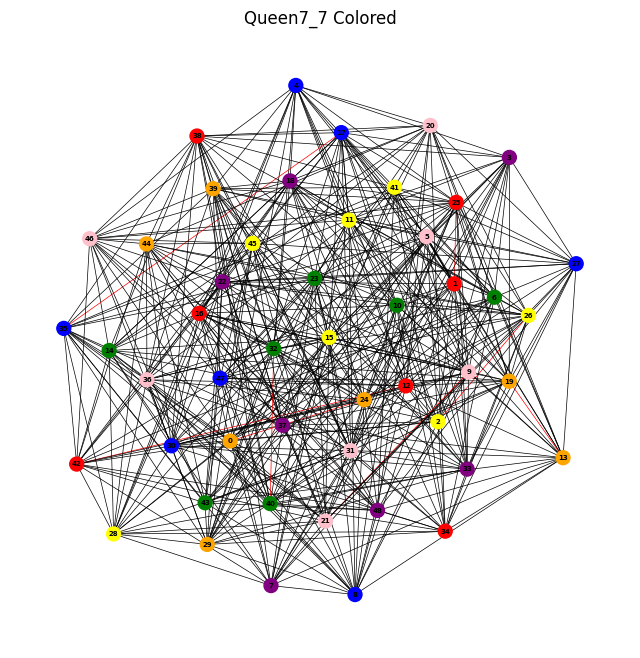

In [ ]:
# Here we set the device: GPU/CPU and the type of the tensors to use
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

# Here we fix a seed to ensure consistent results
SEED_VALUE = 46464
set_seed(SEED_VALUE)

#Here we specify which dataset to use:
problem_file = 'queen7_7.col'

# Here we build the graph for the problem
G_queen7_7 = build_color_graph(problem_file)

#Here we define the hyperparameters
hypers_queen7_7 = {
    'model': 'GraphSAGE',  # Which model to use
    'initial_dim': 67,  # Dimension of the initial embedding
    'hidden_dim': 12,      # Hidden dimension of the model
    'dropout': 0.2339,     # Dropout rate
    'learning_rate': 0.02175, # Learning rate
    'seed': SEED_VALUE,    # Random seed
    'device': TORCH_DEVICE, # Device to use
    'dtype': TORCH_DTYPE,   # Data type to use
    'number_epochs': int(1e5),   # Max number training steps
    'patience': 500,             # Number early stopping triggers before breaking loop
    'graph_file': problem_file,  # Which problem is being solved
    'number_colors': chromatic_numbers[problem_file], # Number of colors in the problem
    'num_nodes': len(G_queen7_7.nodes) # Number of nodes in the problem
}

#Here we initialize the model
net, initial_embedding, optimizer = initialize_model(hypers_queen7_7)

#Here we train the model
probs_queen7_7, best_coloring_queen7_7, best_loss_queen7_7, best_cost_queen7_7 = training(G_queen7_7, net, initial_embedding, optimizer, hypers_queen7_7, verbose=True)
print(f'In this case, the normalized error is: {best_cost_queen7_7/len(G_queen7_7.edges)}')

#Here we obtain a new coloring along with the upper bound for the chromatic number
optimized_coloring_queen7_7, upper_chromatic_number_queen7_7 = new_coloring(G_queen7_7, best_coloring_queen7_7.cpu())
print(f'The upper bound for the chromatic number is: {upper_chromatic_number_queen7_7}')

#Here we concatenate a dataframe with the results for this graph to the results of the other graphs and save it
results_queen7_7 = {
    'Graph': 'queen7_7',
    'Nodes': len(G_queen7_7.nodes),
    'Edges': len(G_queen7_7.edges),
    'Density %':nx.density(G_queen7_7)*100,
    'Colors': chromatic_numbers[problem_file],
    'Chromatic Number': upper_chromatic_number_queen7_7.item(),
    'GraphSAGE Cost': best_cost_queen7_7,
    'Error %':(best_cost_queen7_7/len(G_queen7_7.edges))*100,
}
color_results = pd.read_csv('color_results.csv')
color_results = pd.concat([color_results, pd.DataFrame([results_queen7_7])], ignore_index=True)
color_results.to_csv('color_results.csv', index=False)

#Finally we plot the graph with the coloring
node_colors_queen7_7, edge_colors_queen7_7 = color_lists(G_queen7_7, best_coloring_queen7_7.cpu(), color_map)
#Here we save the graph with this coloring
save_graph(G_queen7_7, node_colors_queen7_7, edge_colors_queen7_7, 'queen7_7', path = 'graphs/')
#Then we plot the graph
plot_graph(G_queen7_7, node_colors= node_colors_queen7_7, edge_colors=edge_colors_queen7_7, seed=SEED_VALUE, node_size = 100, figsize=8, name='Queen7_7 Colored')

As we can see, in this case there are 8 color conflicts. These conflicts can be solved using the heuristic algorithm in ``new_coloring`` by adding more colors. This is why, we found that $\chi = 12$. We will not plot the graph with the new coloring for simplicity.

**4.8.- The Queen8-8 graph**

Now, we will train our GraphSAGE model with the ``queen8_8.col`` graph and its respective hyperparameters.

Will use device: cuda, torch dtype: torch.float32
Setting seed to 46464...
Building GraphSAGE model...
Building ADAM-W optimizer...
Setting seed to 46464...
Epoch: 0 | Soft Loss: 91.93841552734375 | Hard Loss: 255.0 | Patience: 0
Epoch: 1000 | Soft Loss: 27.331024169921875 | Hard Loss: 26.0 | Patience: 0
Epoch: 2000 | Soft Loss: 32.08667755126953 | Hard Loss: 33.0 | Patience: 1
Epoch: 3000 | Soft Loss: 26.134714126586914 | Hard Loss: 25.0 | Patience: 0
Epoch: 4000 | Soft Loss: 27.623207092285156 | Hard Loss: 25.0 | Patience: 1
Epoch: 5000 | Soft Loss: 16.83733558654785 | Hard Loss: 15.0 | Patience: 0
Epoch: 6000 | Soft Loss: 28.166006088256836 | Hard Loss: 28.0 | Patience: 1
Epoch: 7000 | Soft Loss: 26.613325119018555 | Hard Loss: 27.0 | Patience: 0
Epoch: 8000 | Soft Loss: 25.514175415039062 | Hard Loss: 25.0 | Patience: 1
Epoch: 9000 | Soft Loss: 29.407855987548828 | Hard Loss: 31.0 | Patience: 0
Epoch: 10000 | Soft Loss: 20.681964874267578 | Hard Loss: 20.0 | Patience: 1
Epoch: 1100

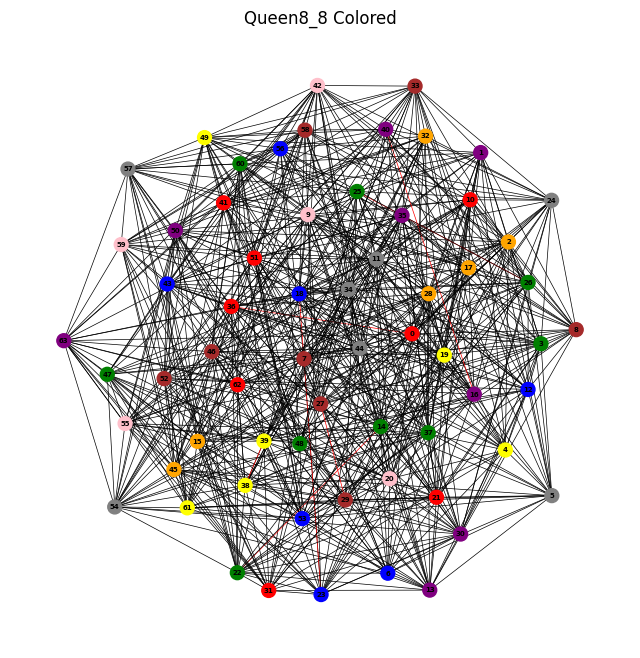

In [ ]:
# Here we set the device: GPU/CPU and the type of the tensors to use
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

# Here we fix a seed to ensure consistent results
SEED_VALUE = 46464
set_seed(SEED_VALUE)

#Here we specify which dataset to use:
problem_file = 'queen8_8.col'

# Here we build the graph for the problem
G_queen8_8 = build_color_graph(problem_file)

#Here we define the hyperparameters
hypers_queen8_8 = {
    'model': 'GraphSAGE',  # Which model to use
    'initial_dim': 32,  # Dimension of the initial embedding
    'hidden_dim': 10,      # Hidden dimension of the model
    'dropout': 0.2878,     # Dropout rate
    'learning_rate': 0.02728, # Learning rate
    'seed': SEED_VALUE,    # Random seed
    'device': TORCH_DEVICE, # Device to use
    'dtype': TORCH_DTYPE,   # Data type to use
    'number_epochs': int(1e5),   # Max number training steps
    'patience': 500,             # Number early stopping triggers before breaking loop
    'graph_file': problem_file,  # Which problem is being solved
    'number_colors': chromatic_numbers[problem_file], # Number of colors in the problem
    'num_nodes': len(G_queen8_8.nodes) # Number of nodes in the problem
}

#Here we initialize the model
net, initial_embedding, optimizer = initialize_model(hypers_queen8_8)

#Here we train the model
probs_queen8_8, best_coloring_queen8_8, best_loss_queen8_8, best_cost_queen8_8 = training(G_queen8_8, net, initial_embedding, optimizer, hypers_queen8_8, verbose=True)
print(f'In this case, the normalized error is: {best_cost_queen8_8/len(G_queen8_8.edges)}')

#Here we obtain a new coloring along with the upper bound for the chromatic number
optimized_coloring_queen8_8, upper_chromatic_number_queen8_8 = new_coloring(G_queen8_8, best_coloring_queen8_8.cpu())
print(f'The upper bound for the chromatic number is: {upper_chromatic_number_queen8_8}')

#Here we concatenate a dataframe with the results for this graph to the results of the other graphs and save it
results_queen8_8 = {
    'Graph': 'queen8_8',
    'Nodes': len(G_queen8_8.nodes),
    'Edges': len(G_queen8_8.edges),
    'Density %':nx.density(G_queen8_8)*100,
    'Colors': chromatic_numbers[problem_file],
    'Chromatic Number': upper_chromatic_number_queen8_8.item(),
    'GraphSAGE Cost': best_cost_queen8_8,
    'Error %':(best_cost_queen8_8/len(G_queen8_8.edges))*100,
}
color_results = pd.read_csv('color_results.csv')
color_results = pd.concat([color_results, pd.DataFrame([results_queen8_8])], ignore_index=True)
color_results.to_csv('color_results.csv', index=False)

#Finally we plot the graph with the coloring
node_colors_queen8_8, edge_colors_queen8_8 = color_lists(G_queen8_8, best_coloring_queen8_8.cpu(), color_map)
#Here we save the graph with this coloring
save_graph(G_queen8_8, node_colors_queen8_8, edge_colors_queen8_8, 'queen8_8', path = 'graphs/')
#Then we plot the graph
plot_graph(G_queen8_8, node_colors= node_colors_queen8_8, edge_colors=edge_colors_queen8_8, seed=SEED_VALUE, node_size = 100, figsize=8, name='Queen8_8 Colored')

As we can see, in this case there are 7 color conflicts. These conflicts can be solved using the heuristic algorithm in ``new_coloring`` by adding more colors. This is why, we found that $\chi = 13$. We will not plot the graph with the new coloring for simplicity.

**4.9.- The Queen8-12 graph**

Now, we will train our GraphSAGE model with the ``queen8_12.col`` graph and its respective hyperparameters.

Will use device: cuda, torch dtype: torch.float32
Setting seed to 8111...
Building GraphSAGE model...
Building ADAM-W optimizer...
Setting seed to 8111...
Epoch: 0 | Soft Loss: 121.34502410888672 | Hard Loss: 420.0 | Patience: 0
Epoch: 1000 | Soft Loss: 14.233330726623535 | Hard Loss: 14.0 | Patience: 1
Epoch: 2000 | Soft Loss: 15.702193260192871 | Hard Loss: 16.0 | Patience: 1
Epoch: 3000 | Soft Loss: 13.923128128051758 | Hard Loss: 14.0 | Patience: 2
Epoch: 4000 | Soft Loss: 13.386475563049316 | Hard Loss: 13.0 | Patience: 0
Epoch: 5000 | Soft Loss: 13.763280868530273 | Hard Loss: 14.0 | Patience: 1
Epoch: 6000 | Soft Loss: 13.83267879486084 | Hard Loss: 14.0 | Patience: 2
Epoch: 7000 | Soft Loss: 13.00620174407959 | Hard Loss: 13.0 | Patience: 0
Epoch: 8000 | Soft Loss: 13.000279426574707 | Hard Loss: 13.0 | Patience: 3
Epoch: 9000 | Soft Loss: 13.0 | Hard Loss: 13.0 | Patience: 0
Epoch: 10000 | Soft Loss: 15.987253189086914 | Hard Loss: 16.0 | Patience: 1
Epoch: 11000 | Soft Loss: 

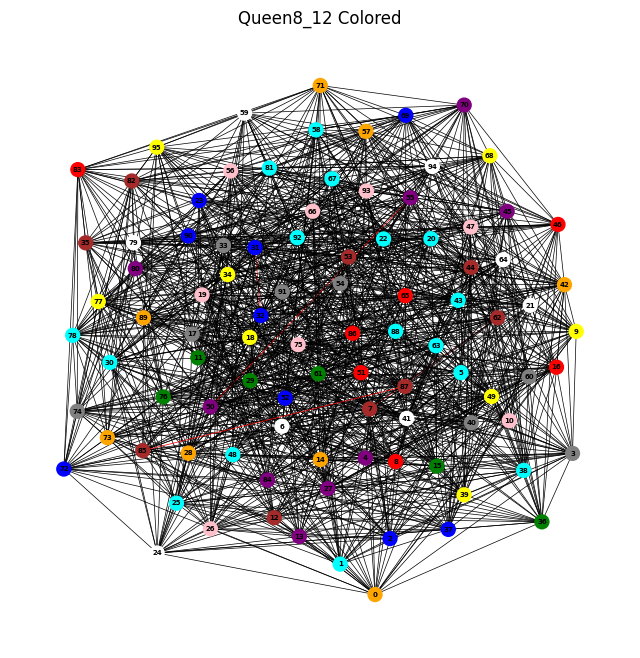

In [ ]:
# Here we set the device: GPU/CPU and the type of the tensors to use
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

# Here we fix a seed to ensure consistent results
SEED_VALUE = 8111
set_seed(SEED_VALUE)

#Here we specify which dataset to use:
problem_file = 'queen8_12.col'

# Here we build the graph for the problem
G_queen8_12 = build_color_graph(problem_file)

#Here we define the hyperparameters
hypers_queen8_12 = {
    'model': 'GraphSAGE',  # Which model to use
    'initial_dim': 107,  # Dimension of the initial embedding
    'hidden_dim': 23,      # Hidden dimension of the model
    'dropout': 0.1796,     # Dropout rate
    'learning_rate': 0.01730, # Learning rate
    'seed': SEED_VALUE,    # Random seed
    'device': TORCH_DEVICE, # Device to use
    'dtype': TORCH_DTYPE,   # Data type to use
    'number_epochs': int(1e5),   # Max number training steps
    'patience': 500,             # Number early stopping triggers before breaking loop
    'graph_file': problem_file,  # Which problem is being solved
    'number_colors': chromatic_numbers[problem_file], # Number of colors in the problem
    'num_nodes': len(G_queen8_12.nodes) # Number of nodes in the problem
}

#Here we initialize the model
net, initial_embedding, optimizer = initialize_model(hypers_queen8_12)

#Here we train the model
probs_queen8_12, best_coloring_queen8_12, best_loss_queen8_12, best_cost_queen8_12 = training(G_queen8_12, net, initial_embedding, optimizer, hypers_queen8_12, verbose=True)
print(f'In this case, the normalized error is: {best_cost_queen8_12/len(G_queen8_12.edges)}')

#Here we obtain a new coloring along with the upper bound for the chromatic number
optimized_coloring_queen8_12, upper_chromatic_number_queen8_12 = new_coloring(G_queen8_12, best_coloring_queen8_12.cpu())
print(f'The upper bound for the chromatic number is: {upper_chromatic_number_queen8_12}')

#Here we concatenate a dataframe with the results for this graph to the results of the other graphs and save it
results_queen8_12 = {
    'Graph': 'queen8_12',
    'Nodes': len(G_queen8_12.nodes),
    'Edges': len(G_queen8_12.edges),
    'Density %':nx.density(G_queen8_12)*100,
    'Colors': chromatic_numbers[problem_file],
    'Chromatic Number': upper_chromatic_number_queen8_12.item(),
    'GraphSAGE Cost': best_cost_queen8_12,
    'Error %':(best_cost_queen8_12/len(G_queen8_12.edges))*100,
}
color_results = pd.read_csv('color_results.csv')
color_results = pd.concat([color_results, pd.DataFrame([results_queen8_12])], ignore_index=True)
color_results.to_csv('color_results.csv', index=False)

#Finally we plot the graph with the coloring
node_colors_queen8_12, edge_colors_queen8_12 = color_lists(G_queen8_12, best_coloring_queen8_12.cpu(), color_map)
#Here we save the graph with this coloring
save_graph(G_queen8_12, node_colors_queen8_12, edge_colors_queen8_12, 'queen8_12', path = 'graphs/')
#Then we plot the graph
plot_graph(G_queen8_12, node_colors= node_colors_queen8_12, edge_colors=edge_colors_queen8_12, seed=SEED_VALUE, node_size = 100, figsize=8, name='Queen8_12 Colored')

As we can see, in this case there are 4 color conflicts. These conflicts can be solved using the heuristic algorithm in ``new_coloring`` by adding more colors. This is why, we found that $\chi = 14$. We will not plot the graph with the new coloring for simplicity.

**4.10.- The Queen9-9 graph**

Now, we will train our GraphSAGE model with the ``queen9_9.col`` graph and its respective hyperparameters.

Will use device: cuda, torch dtype: torch.float32
Setting seed to 8111...
Building GraphSAGE model...
Building ADAM-W optimizer...
Setting seed to 8111...
Epoch: 0 | Soft Loss: 108.46098327636719 | Hard Loss: 169.0 | Patience: 0
Epoch: 1000 | Soft Loss: 32.17713165283203 | Hard Loss: 33.0 | Patience: 1
Epoch: 2000 | Soft Loss: 31.0166015625 | Hard Loss: 30.0 | Patience: 1
Epoch: 3000 | Soft Loss: 29.496261596679688 | Hard Loss: 30.0 | Patience: 1
Epoch: 4000 | Soft Loss: 21.0424747467041 | Hard Loss: 21.0 | Patience: 2
Epoch: 5000 | Soft Loss: 25.28417205810547 | Hard Loss: 26.0 | Patience: 1
Epoch: 6000 | Soft Loss: 18.5031795501709 | Hard Loss: 18.0 | Patience: 0
Epoch: 7000 | Soft Loss: 30.482765197753906 | Hard Loss: 31.0 | Patience: 1
Epoch: 8000 | Soft Loss: 15.796988487243652 | Hard Loss: 16.0 | Patience: 0
Epoch: 9000 | Soft Loss: 24.069889068603516 | Hard Loss: 25.0 | Patience: 1
Epoch: 10000 | Soft Loss: 18.972089767456055 | Hard Loss: 18.0 | Patience: 3
Epoch: 11000 | Soft L

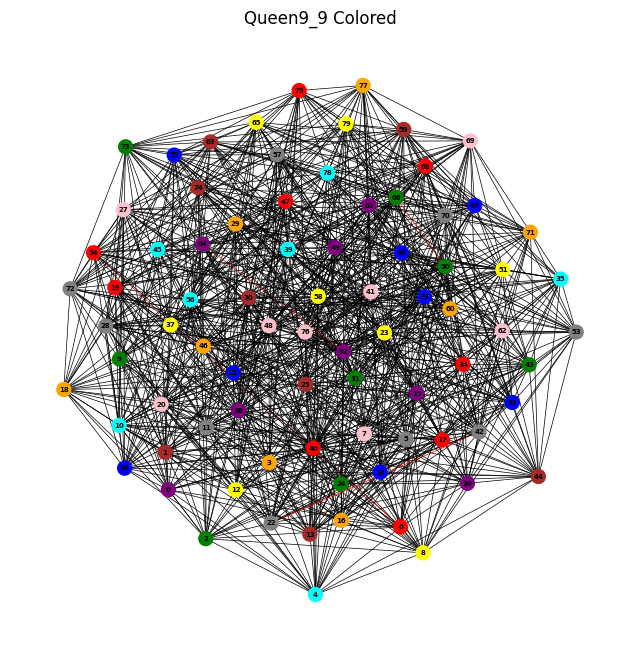

In [ ]:
# Here we set the device: GPU/CPU and the type of the tensors to use
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

# Here we fix a seed to ensure consistent results
SEED_VALUE = 8111
set_seed(SEED_VALUE)

#Here we specify which dataset to use:
problem_file = 'queen9_9.col'

# Here we build the graph for the problem
G_queen9_9 = build_color_graph(problem_file)

#Here we define the hyperparameters
hypers_queen9_9 = {
    'model': 'GraphSAGE',  # Which model to use
    'initial_dim': 109,  # Dimension of the initial embedding
    'hidden_dim': 16,      # Hidden dimension of the model
    'dropout': 0.3257,     # Dropout rate
    'learning_rate': 0.02636, # Learning rate
    'seed': SEED_VALUE,    # Random seed
    'device': TORCH_DEVICE, # Device to use
    'dtype': TORCH_DTYPE,   # Data type to use
    'number_epochs': int(1e5),   # Max number training steps
    'patience': 500,             # Number early stopping triggers before breaking loop
    'graph_file': problem_file,  # Which problem is being solved
    'number_colors': chromatic_numbers[problem_file], # Number of colors in the problem
    'num_nodes': len(G_queen9_9.nodes) # Number of nodes in the problem
}

#Here we initialize the model
net, initial_embedding, optimizer = initialize_model(hypers_queen9_9)

#Here we train the model
probs_queen9_9, best_coloring_queen9_9, best_loss_queen9_9, best_cost_queen9_9 = training(G_queen9_9, net, initial_embedding, optimizer, hypers_queen9_9, verbose=True)
print(f'In this case, the normalized error is: {best_cost_queen9_9/len(G_queen9_9.edges)}')

#Here we obtain a new coloring along with the upper bound for the chromatic number
optimized_coloring_queen9_9, upper_chromatic_number_queen9_9 = new_coloring(G_queen9_9, best_coloring_queen9_9.cpu())
print(f'The upper bound for the chromatic number is: {upper_chromatic_number_queen9_9}')

#Here we concatenate a dataframe with the results for this graph to the results of the other graphs and save it
results_queen9_9 = {
    'Graph': 'queen9_9',
    'Nodes': len(G_queen9_9.nodes),
    'Edges': len(G_queen9_9.edges),
    'Density %':nx.density(G_queen9_9)*100,
    'Colors': chromatic_numbers[problem_file],
    'Chromatic Number': upper_chromatic_number_queen9_9.item(),
    'GraphSAGE Cost': best_cost_queen9_9,
    'Error %':(best_cost_queen9_9/len(G_queen9_9.edges))*100,
}
color_results = pd.read_csv('color_results.csv')
color_results = pd.concat([color_results, pd.DataFrame([results_queen9_9])], ignore_index=True)
color_results.to_csv('color_results.csv', index=False)

#Finally we plot the graph with the coloring
node_colors_queen9_9, edge_colors_queen9_9 = color_lists(G_queen9_9, best_coloring_queen9_9.cpu(), color_map)
#Here we save the graph with this coloring
save_graph(G_queen9_9, node_colors_queen9_9, edge_colors_queen9_9, 'queen9_9', path = 'graphs/')
#Then we plot the graph
plot_graph(G_queen9_9, node_colors= node_colors_queen9_9, edge_colors=edge_colors_queen9_9, seed=SEED_VALUE, node_size = 100, figsize=8, name='Queen9_9 Colored')

As we can see, in this case there are 4 color conflicts. These conflicts can be solved using the heuristic algorithm in ``new_coloring`` by adding more colors. This is why, we found that $\chi = 12$. We will not plot the graph with the new coloring for simplicity.

**4.11.- The Queen11-11 graph**

Now, we will train our GraphSAGE model with the ``queen11_11.col`` graph and its respective hyperparameters.

Will use device: cuda, torch dtype: torch.float32
Setting seed to 8111...
Building GraphSAGE model...
Building ADAM-W optimizer...
Setting seed to 8111...
Epoch: 0 | Soft Loss: 188.32786560058594 | Hard Loss: 491.0 | Patience: 0
Epoch: 1000 | Soft Loss: 60.553733825683594 | Hard Loss: 60.0 | Patience: 2
Epoch: 2000 | Soft Loss: 55.793983459472656 | Hard Loss: 54.0 | Patience: 0
Epoch: 3000 | Soft Loss: 51.83334732055664 | Hard Loss: 50.0 | Patience: 0
Epoch: 4000 | Soft Loss: 55.960784912109375 | Hard Loss: 56.0 | Patience: 1
Epoch: 5000 | Soft Loss: 47.53628158569336 | Hard Loss: 47.0 | Patience: 1
Epoch: 6000 | Soft Loss: 46.75379180908203 | Hard Loss: 50.0 | Patience: 0
Epoch: 7000 | Soft Loss: 58.015663146972656 | Hard Loss: 59.0 | Patience: 1
Epoch: 8000 | Soft Loss: 44.53688049316406 | Hard Loss: 44.0 | Patience: 0
Epoch: 9000 | Soft Loss: 41.52967071533203 | Hard Loss: 42.0 | Patience: 3
Epoch: 10000 | Soft Loss: 51.71289825439453 | Hard Loss: 49.0 | Patience: 3
Epoch: 11000 | S

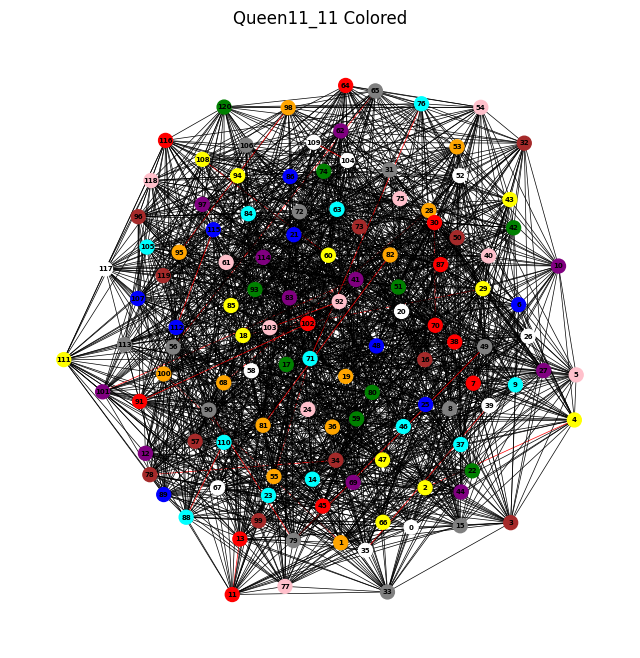

In [ ]:
# Here we set the device: GPU/CPU and the type of the tensors to use
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

# Here we fix a seed to ensure consistent results
SEED_VALUE = 8111
set_seed(SEED_VALUE)

#Here we specify which dataset to use:
problem_file = 'queen11_11.col'

# Here we build the graph for the problem
G_queen11_11 = build_color_graph(problem_file)

#Here we define the hyperparameters
hypers_queen11_11 = {
    'model': 'GraphSAGE',  # Which model to use
    'initial_dim': 75,  # Dimension of the initial embedding
    'hidden_dim': 25,      # Hidden dimension of the model
    'dropout': 0.2974,     # Dropout rate
    'learning_rate': 0.04600, # Learning rate
    'seed': SEED_VALUE,    # Random seed
    'device': TORCH_DEVICE, # Device to use
    'dtype': TORCH_DTYPE,   # Data type to use
    'number_epochs': int(1e5),   # Max number training steps
    'patience': 500,             # Number early stopping triggers before breaking loop
    'graph_file': problem_file,  # Which problem is being solved
    'number_colors': chromatic_numbers[problem_file], # Number of colors in the problem
    'num_nodes': len(G_queen11_11.nodes) # Number of nodes in the problem
}

#Here we initialize the model
net, initial_embedding, optimizer = initialize_model(hypers_queen11_11)

#Here we train the model
probs_queen11_11, best_coloring_queen11_11, best_loss_queen11_11, best_cost_queen11_11 = training(G_queen11_11, net, initial_embedding, optimizer, hypers_queen11_11, verbose=True)
print(f'In this case, the normalized error is: {best_cost_queen11_11/len(G_queen11_11.edges)}')

#Here we obtain a new coloring along with the upper bound for the chromatic number
optimized_coloring_queen11_11, upper_chromatic_number_queen11_11 = new_coloring(G_queen11_11, best_coloring_queen11_11.cpu())
print(f'The upper bound for the chromatic number is: {upper_chromatic_number_queen11_11}')

#Here we concatenate a dataframe with the results for this graph to the results of the other graphs and save it
results_queen11_11 = {
    'Graph': 'queen11_11',
    'Nodes': len(G_queen11_11.nodes),
    'Edges': len(G_queen11_11.edges),
    'Density %':nx.density(G_queen11_11)*100,
    'Colors': chromatic_numbers[problem_file],
    'Chromatic Number': upper_chromatic_number_queen11_11.item(),
    'GraphSAGE Cost': best_cost_queen11_11,
    'Error %':(best_cost_queen11_11/len(G_queen11_11.edges))*100,
}
color_results = pd.read_csv('color_results.csv')
color_results = pd.concat([color_results, pd.DataFrame([results_queen11_11])], ignore_index=True)
color_results.to_csv('color_results.csv', index=False)

#Finally we plot the graph with the coloring
node_colors_queen11_11, edge_colors_queen11_11 = color_lists(G_queen11_11, best_coloring_queen11_11.cpu(), color_map)
#Here we save the graph with this coloring
save_graph(G_queen11_11, node_colors_queen11_11, edge_colors_queen11_11, 'queen11_11', path = 'graphs/')
#Then we plot the graph
plot_graph(G_queen11_11, node_colors= node_colors_queen11_11, edge_colors=edge_colors_queen11_11, seed=SEED_VALUE, node_size = 100, figsize=8, name='Queen11_11 Colored')

As we can see, in this case there are 22 color conflicts. These conflicts can be solved using the heuristic algorithm in ``new_coloring`` by adding more colors. This is why, we found that $\chi = 23$. We will not plot the graph with the new coloring for simplicity.

# 5.- Final Remarks

**5.1.- The GraphSAGE and GCN results**

The final hard cost $H_{Potts}$ and normalized error $\epsilon$ results for the COLOR dataset using the GraphSAGE model can be visualized in the following table:

In [7]:
color_results = pd.read_csv('color_results.csv')
color_results

Graph  Nodes  Edges  Density %  Colors  Chromatic Number  \
0         anna    138    493   5.215276      11                11   
1         jean     77    254   8.680793      10                10   
2      myciel5     47    236  21.831637       6                 6   
3      myciel6     95    755  16.909295       7                 7   
4     queen5_5     25    160  53.333333       5                 5   
5     queen6_6     36    290  46.031746       7                 8   
6     queen7_7     49    476  40.476190       7                12   
7     queen8_8     64    728  36.111111       9                13   
8    queen8_12     96   1368  30.000000      12                14   
9     queen9_9     81   1056  32.592593      10                12   
10  queen11_11    121   1980  27.272727      11                23   

    GraphSAGE Cost   Error %  
0              0.0  0.000000  
1              0.0  0.000000  
2              0.0  0.000000  
3              0.0  0.000000  
4              0.0  0.000000  
5              1.0  0.344828  
6              8.0  1.680672  
7              7.0  0.961538  
8              4.0  0.292398  
9              4.0  0.378788  
10            22.0  1.111111

If compared with the results obtained by Schuetz et al. [2022](https://doi.org/10.48550/arXiv.2202.01606):

\\

| **Graph**      | **Nodes** | **Edges** | **Density** | **color $q$** | **PI $\chi$** | **$\chi$** | **PI-SAGE $H$** | **GraphSAGE $H$** | **PI error $\epsilon$** | **error $\epsilon$** |
|----------------|-----------|-----------|-------------|---------------|---------------|------------|-----------------|-------------------|-------------------------|----------------------|
| **anna**       | 138       | 493       | 5.21%       | 11            | 11            | 11         | 0               | 0                 | 0.00%                   | 0.00%                |
| **jean**       | 77        | 254       | 8.68%       | 10            | 10            | 10         | 0               | 0                 | 0.00%                   | 0.00%                |
| **myciel5**    | 47        | 236       | 21.83%      | 6             | 6             | 6          | 0               | 0                 | 0.00%                   | 0.00%                |
| **myciel6**    | 95        | 755       | 16.9%       | 7             | 7             | 7          | 0               | 0                 | 0.00%                   | 0.00%                |
| **queen5_5**   | 25        | 160       | 53.33%      | 5             | 5             | 5          | 0               | 0                 | 0.00%                   | 0.00%                |
| **queen6_6**   | 36        | 290       | 46.03%      | 7             | 7             | 8          | 0               | 1                 | 0.00%                   | 0.34%                |
| **queen7_7**   | 49        | 476       | 40.47%      | 7             | 7             | 12         | 0               | 8                 | 0.00%                   | 1.68%                |
| **queen8_8**   | 64        | 728       | 36.11%      | 9             | 10            | 13         | 1               | 7                 | 0.14%                   | 0.96%                |
| **queen8_12**  | 96        | 1368      | 30.0%       | 12            | 12            | 14         | 0               | 4                 | 0.00%                   | 0.29%                |
| **queen9_9**   | 81        | 1056      | 32.59%      | 10            | 11            | 12         | 1               | 4                 | 0.09%                   | 0.37%                |
| **queen11_11** | 121       | 1980      | 27.27%      | 11            | 14            | 23         | 17              | 22                | 0.86%                   | 1.11%                |

\\

where the PI-SAGE $H$, PI $\epsilon$ and PI $\chi$ are the results found by Schuetz et al. [2022](https://doi.org/10.48550/arXiv.2202.01606) using their GraphSAGE model.

We can observe the following:

- We obtained the same normalized error for the ``anna``, ``jean``, ``myciel5``, ``myciel6``, and ``queen5-5`` graphs and for all of them we found an optimal coloring with zero cost, as long as a minimal upper value for the chromatic number $\chi$.

- Even though we couldn't achieve the same results for the remaining graphs, we can observe that we consistently found normalized errors $\epsilon <1\%$ except for the ``queen7-7`` and ``queen11-11`` graphs (i.e. a highly dense and a "big" graph).

We can also add to the discussion the results for our GCN model applied to the ``queen5-5`` graph on the first part of this Notebook:

\\

| **Graph**    | **Nodes** | **Edges** | **Density** | **color $q$** | **PI $\chi$** | **$\chi$** | **PI-GCN $H$** | **GCN $H$** | **PI error $\epsilon$** | **error $\epsilon$** |
|--------------|-----------|-----------|-------------|---------------|---------------|------------|----------------|-------------|-------------------------|----------------------|
| **queen5-5** | 25        | 160       | 53.33%      | 5             | 5             | 5          | 0              | 0           | 0.00%                   | 0.00%                |

\\

where we can also observe that we achieved exactly the same results as the results obtained by Schuetz et al. [2022](https://doi.org/10.48550/arXiv.2202.01606).

**5.2.- Conclusions**

Overall we were able to achieve similar results to the ones presented by Schuetz et al. [2022](https://doi.org/10.48550/arXiv.2202.01606) given that we didn't perform hyperparameter tuning to our model and used directly the hyperparameters given by the authors even though they used the ``DGL`` library to construct their models. For example, these models define a GCN layer as:


$$ \vec{h}_{v}^{k} = \sigma \left( b^{k}+ \sum_{u\in \mathbf{N}_{v}} W_{k}\frac{\vec{h}_{u}^{k-1}}{\sqrt{d_{u}d_{v}}} \right)$$

\\

whereas the ``Torch Geometric`` framework defines it as:

\\

$$ \vec{h}_{v}^{k} = \sigma \left(W_{k} \sum_{u\in \mathbf{N}_{v}\cup \{v\}} \frac{\vec{h}_{u}^{k-1}}{\sqrt{d_{u}d_{v}}} \right)$$

\\

For better training and better results we propose performing hyperparameter tuning to the following hyperparameters:

- ``learning rate``
- ``initial_dimension``
- ``hidden_dimension``

since in general, the Potts Soft Loss often oscillated between values or got stuck in high values as well.